## *IMPORT MODULES*

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

## *Read in train, test and valid images and create train, test and validation data frames*

### using train, test and valid directories

In [8]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )       
    for klass in classlist:
        classpath=os.path.join(sdir, klass)           
        flist=sorted(os.listdir(classpath)) 
        desc=f'{klass:25s}'
        for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123,stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())     
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'../input/eye-diseases-classification/dataset'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)

normal                   : 100%|███████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 498857.42files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  768   the minimum files in any class in train_df is  705
train_df length:  2951   test_df length:  633   valid_df length:  633
average image height=  510   average image width=  578  aspect ratio h/w=  0.8823529411764706


## *Trim train_df so no class has more than 300 images*

In [9]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=700
min_samples=700
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  2951  with  4  classes
after trimming, the maximum samples in any class is now  700  and the minimum samples in any class is  700
the trimmed dataframe now is of length  2800  with  4  classes


In [10]:
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of  images

### *Create the train_gen, test_gen final_test_gen and valid_gen*

In [11]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2800 validated image filenames belonging to 4 classes.           for train generator 
Found 633 validated image filenames belonging to 4 classes.            for valid generator 
Found 633 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  3   test steps:  211  number of classes :  4


### *Create a function to show example training images*

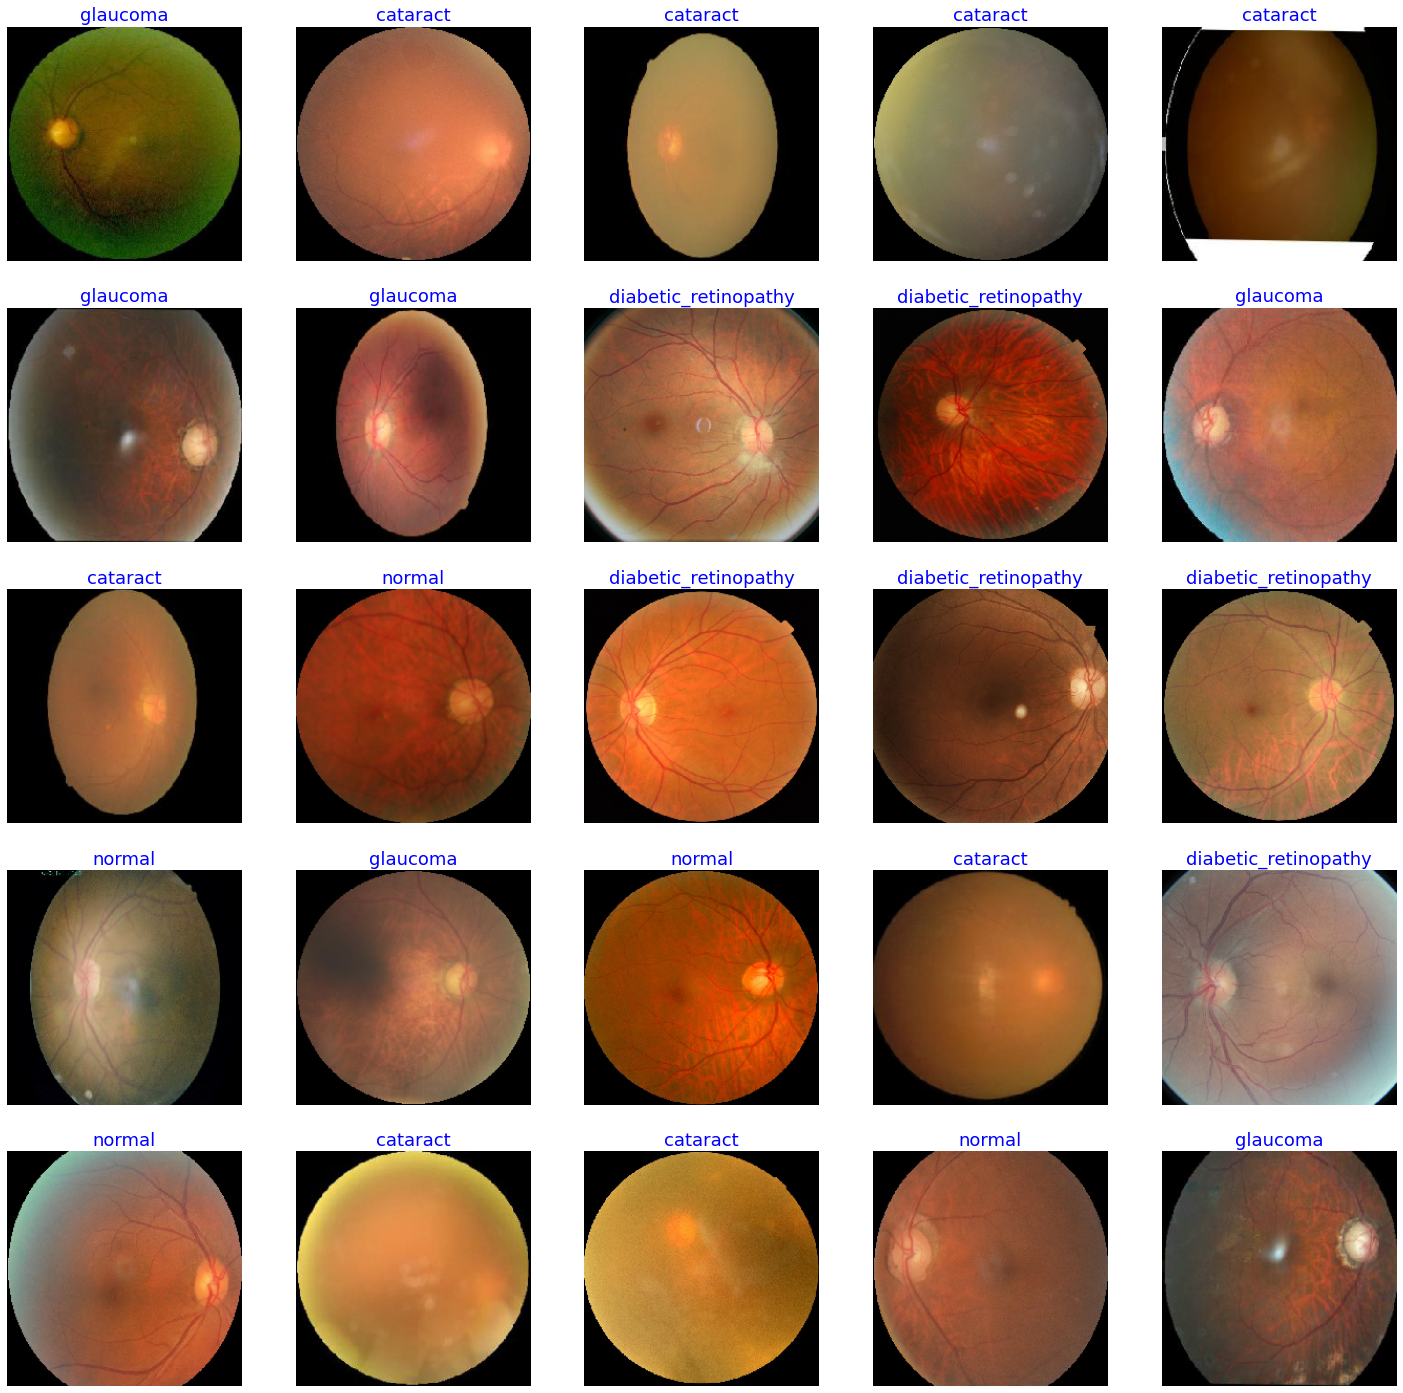

In [12]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

## *Model Creation*

| Mode | Model |
| :---:        |    :----:   |
|  0 | VGG19 |
| 3 | Efficient Net B3 |
|5 | InceptionV3 |
|  any other value | ResNet50 |

| optimizer_mode | optimizer |
| :---:        |    :----:   |
|  1 | SGD |
| 2 | Adam |
|3 | Adamax |

In [13]:
def make_model_VGG(img_size, lr, optimizer_mode=3):  # using Adamax optimizer by default
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    msg='Created VGG19 model'  

    base_model.trainable=False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    if optimizer_mode == 1:
        model.compile(SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg='Created VGG19 model with SGD optimizer'
    if optimizer_mode == 2:
        model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg='Created VGG19 model with Adam optimizer'
    if optimizer_mode == 3:
        model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg='Created VGG19 model with Adamax optimizer'
        
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    model.summary()
    return model

lr=.001

### *Create a custom Keras callback to continue and optionally set LR or halt training*

In [14]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg)
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

### *Define a function to plot and save the training data*

In [15]:
def tr_plot(tr_data, start_epoch, file_name):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    tpre=tr_data.history['precision']
    trec=tr_data.history['recall']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    vpre=tr_data.history['val_precision']
    vrec=tr_data.history['val_recall']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    index_pre=np.argmax(vpre)
    pre_highest=vpre[index_pre]
    index_rec=np.argmax(vrec)
    rec_highest=vrec[index_rec]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    pc_label='best epoch= '+ str(index_pre + 1+ start_epoch)
    rc_label='best epoch= '+ str(index_rec + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(25,10))
    axes[0][0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0][0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0][0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0][0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0][0].set_title('Training and Validation Loss')
    axes[0][0].set_xlabel('Epochs', fontsize=18)
    axes[0][0].set_ylabel('Loss', fontsize=18)
    axes[0][0].legend()
    axes[0][1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[0][1].scatter(Epochs, tacc, s=100, c='red')
    axes[0][1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[0][1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[0][1].set_title('Training and Validation Accuracy')
    axes[0][1].set_xlabel('Epochs', fontsize=18)
    axes[0][1].set_ylabel('Accuracy', fontsize=18)
    axes[0][1].legend()
    axes[1][0].plot(Epochs,tpre, 'r', label='Training Precison')
    axes[1][0].plot(Epochs,vpre,'g',label='Validation Precision' )
    axes[1][0].scatter(index_pre+1 +start_epoch,pre_highest, s=150, c= 'blue', label=pc_label)
    axes[1][0].scatter(Epochs, tpre, s=100, c='red')    
    axes[1][0].set_title('Training and Validation Precision')
    axes[1][0].set_xlabel('Epochs', fontsize=18)
    axes[1][0].set_ylabel('Precision', fontsize=18)
    axes[1][0].legend()
    axes[1][1].plot(Epochs,trec, 'r', label='Training Recall')
    axes[1][1].plot(Epochs,vrec,'g',label='Validation Recall' )
    axes[1][1].scatter(index_rec+1 +start_epoch,rec_highest, s=150, c= 'blue', label=rc_label)
    axes[1][1].scatter(Epochs, trec, s=100, c='red')    
    axes[1][1].set_title('Training and Validation Recall')
    axes[1][1].set_xlabel('Epochs', fontsize=18)
    axes[1][1].set_ylabel('Recall', fontsize=18)
    axes[1][1].legend()
    plt.tight_layout(h_pad=0.8,w_pad=0.2)    
    plt.show()
    plt.savefig(file_name)
    return index_loss

### *Make Predictions on the test set*

In [16]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg) 
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    print("Accuracy for classes in order C, D, G, N:\n----------------------\n",cm.diagonal()/cm.sum(axis=1))
    return errors, tests, error_list, error_pred_list, f1score

### VGG19 with SGD, Adam, Adamax optimizers

#### VGG19 with SGD

In [17]:
model=make_model_VGG(img_size, lr, optimizer_mode=1)
# instantiate custom callback
epochs=100
ask_epoch=20
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

80150528/80134624 [==============================] - 0s 0us/step
Created VGG19 model with SGD optimizer with initial learning rate set to 0.001
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128

 H


you entered H,  Training halted on epoch 20 due to user input

loading model with weights from epoch 20
training elapsed time was 0.0 hours, 21.0 minutes, 54.65 seconds)


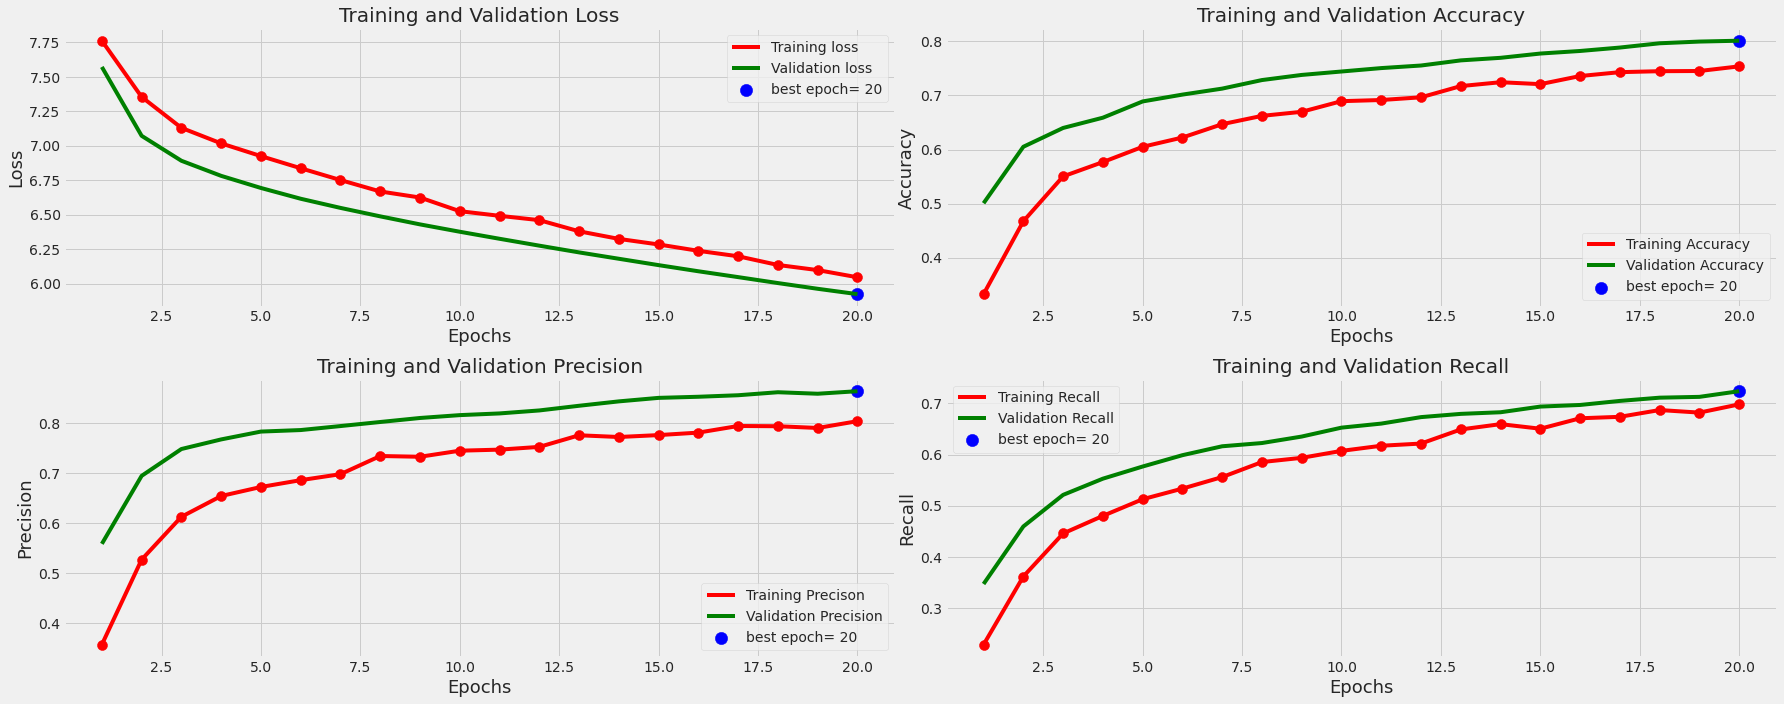

19
211/211 [==============================] - 9s 44ms/step
there were 116 errors in 633 tests for an accuracy of  81.67


<Figure size 432x288 with 0 Axes>

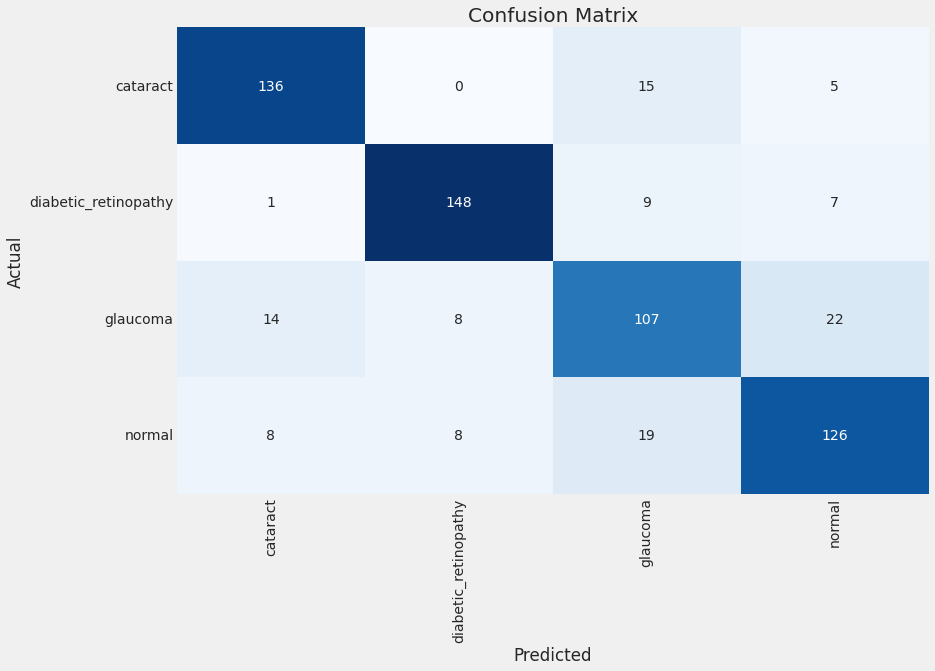

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.8553    0.8718    0.8635       156
diabetic_retinopathy     0.9024    0.8970    0.8997       165
            glaucoma     0.7133    0.7086    0.7110       151
              normal     0.7875    0.7826    0.7850       161

            accuracy                         0.8167       633
           macro avg     0.8147    0.8150    0.8148       633
        weighted avg     0.8165    0.8167    0.8166       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.87179487 0.8969697  0.70860927 0.7826087 ]
81.6591808880156


In [18]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'vgg19sgd.pdf')
print(loss_index)

# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### VGG19 with Adam

In [19]:
model=make_model_VGG(img_size, lr, optimizer_mode=2)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created VGG19 model with Adam optimizer with initial learning rate set to 0.001
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________

 3


you entered 3 Training will continue to epoch 8
Epoch 6/40
94/94 [==============================] - 36s 389ms/step - loss: 0.7138 - accuracy: 0.8929 - precision: 0.9203 - recall: 0.8582 - val_loss: 0.7314 - val_accuracy: 0.8673 - val_precision: 0.8924 - val_recall: 0.8389

 validation loss of  0.7314 is  4.9750 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 36s 378ms/step - loss: 0.6789 - accuracy: 0.8929 - precision: 0.9168 - recall: 0.8582 - val_loss: 0.6890 - val_accuracy: 0.8799 - val_precision: 0.9052 - val_recall: 0.8594

 validation loss of  0.6890 is  5.7943 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 36s 382ms/step - loss: 0.6443 - accuracy: 0.9021 - precision: 0.9223 - recall: 0.8696 - val_loss: 0.6930 - val_accuracy: 0.8752 - val_precision: 0.8909 - val_recall: 0.8389

 validation loss of  0.6930 is  0.5793 % above lowest loss of 

 H


you entered H,  Training halted on epoch 8 due to user input

loading model with weights from epoch 7
training elapsed time was 0.0 hours,  5.0 minutes, 12.98 seconds)


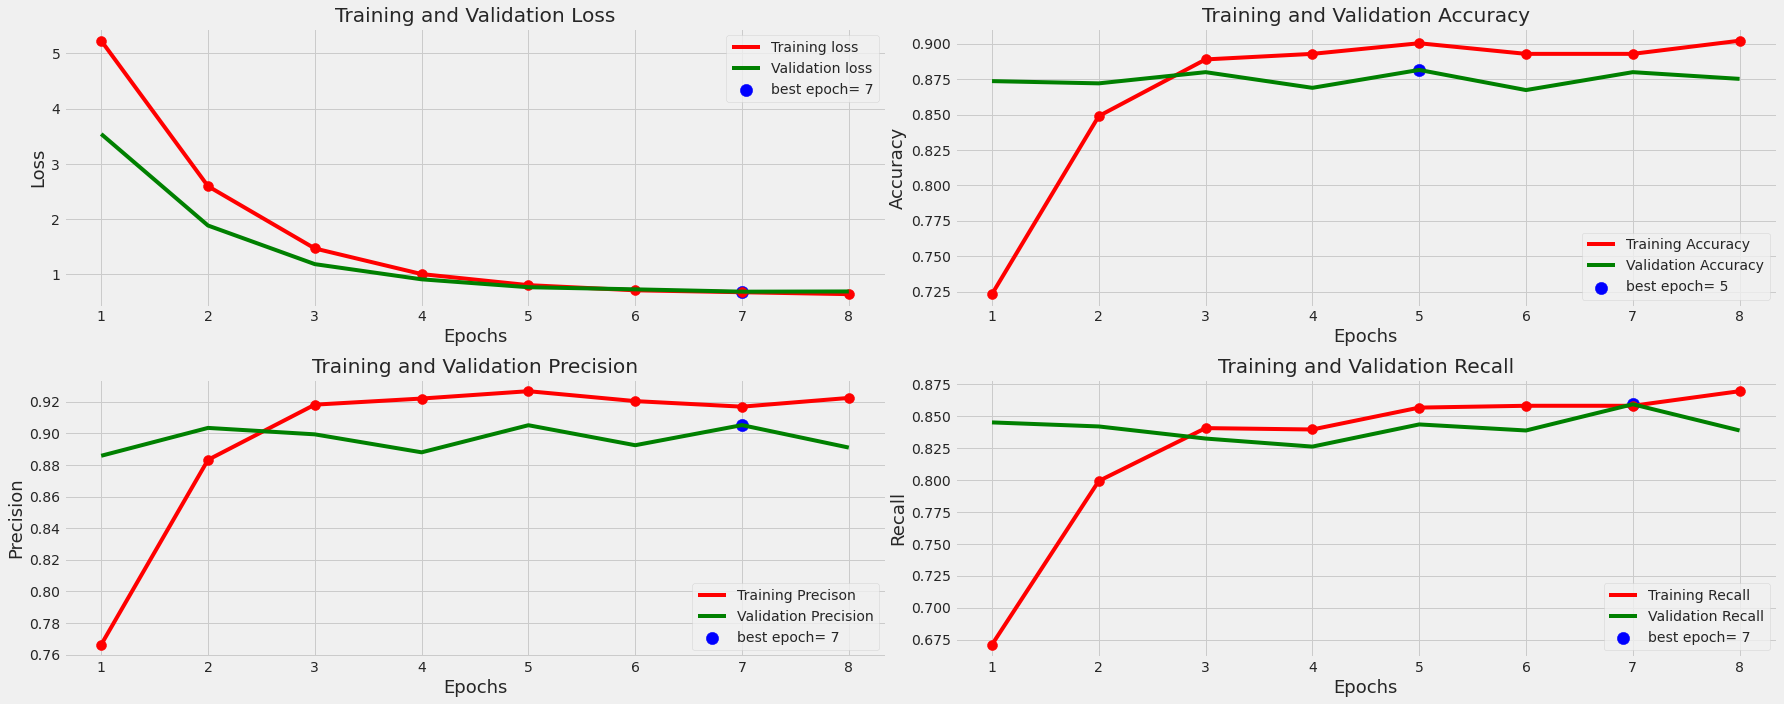

6
211/211 [==============================] - 8s 36ms/step
there were 75 errors in 633 tests for an accuracy of  88.15


<Figure size 432x288 with 0 Axes>

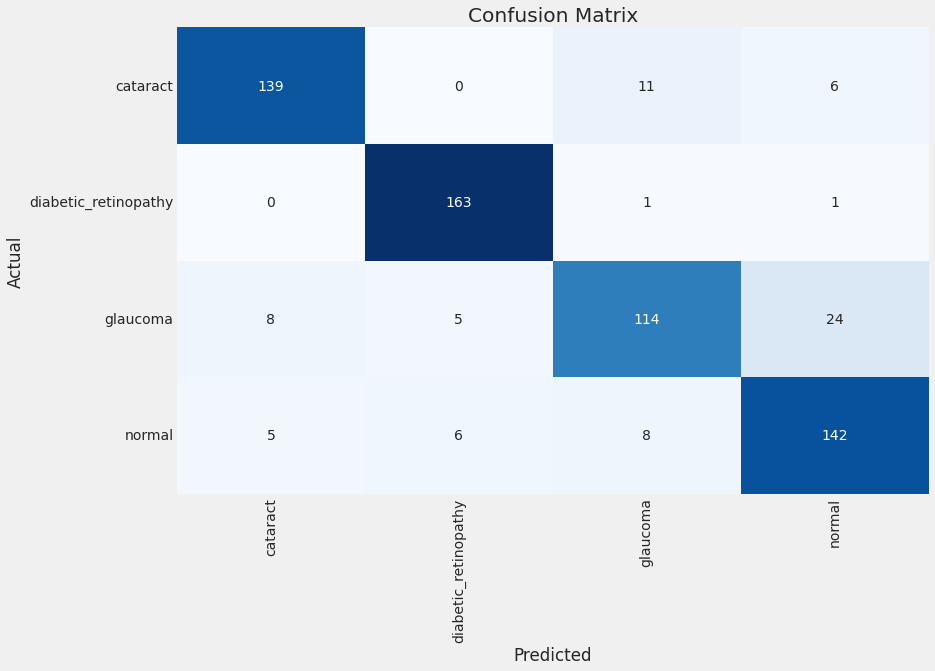

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9145    0.8910    0.9026       156
diabetic_retinopathy     0.9368    0.9879    0.9617       165
            glaucoma     0.8507    0.7550    0.8000       151
              normal     0.8208    0.8820    0.8503       161

            accuracy                         0.8815       633
           macro avg     0.8807    0.8790    0.8786       633
        weighted avg     0.8813    0.8815    0.8802       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.89102564 0.98787879 0.75496689 0.88198758]
88.02147942649141


In [20]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'vgg19adam.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### VGG19 with Adamax

In [21]:
model=make_model_VGG(img_size, lr)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created VGG19 model with Adamax optimizer with initial learning rate set to 0.001
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

 3


you entered 3 Training will continue to epoch 8
Epoch 6/40
94/94 [==============================] - 36s 385ms/step - loss: 2.1483 - accuracy: 0.8993 - precision: 0.9292 - recall: 0.8525 - val_loss: 1.9936 - val_accuracy: 0.8815 - val_precision: 0.9160 - val_recall: 0.8436

 validation loss of  1.9936 is 15.9758 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 36s 384ms/step - loss: 1.8053 - accuracy: 0.9043 - precision: 0.9350 - recall: 0.8625 - val_loss: 1.6966 - val_accuracy: 0.8847 - val_precision: 0.9162 - val_recall: 0.8468

 validation loss of  1.6966 is 14.8981 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 36s 385ms/step - loss: 1.5258 - accuracy: 0.9111 - precision: 0.9390 - recall: 0.8682 - val_loss: 1.4561 - val_accuracy: 0.8894 - val_precision: 0.9139 - val_recall: 0.8547

 validation loss of  1.4561 is 14.1784 % below lowest loss, sa

 H


you entered H,  Training halted on epoch 8 due to user input

loading model with weights from epoch 8
training elapsed time was 0.0 hours,  6.0 minutes, 54.08 seconds)


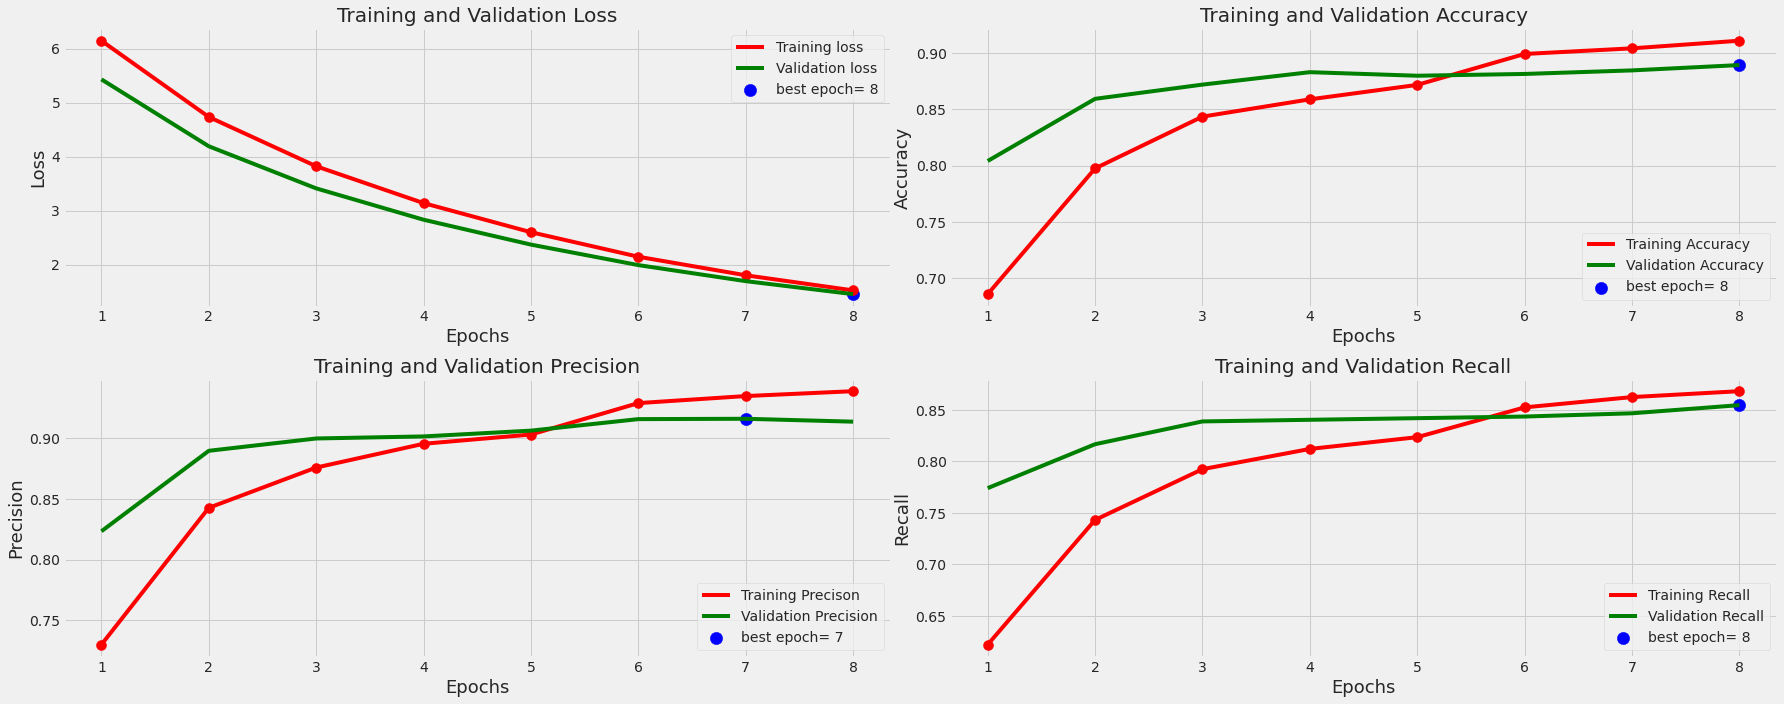

7
211/211 [==============================] - 7s 35ms/step
there were 70 errors in 633 tests for an accuracy of  88.94


<Figure size 432x288 with 0 Axes>

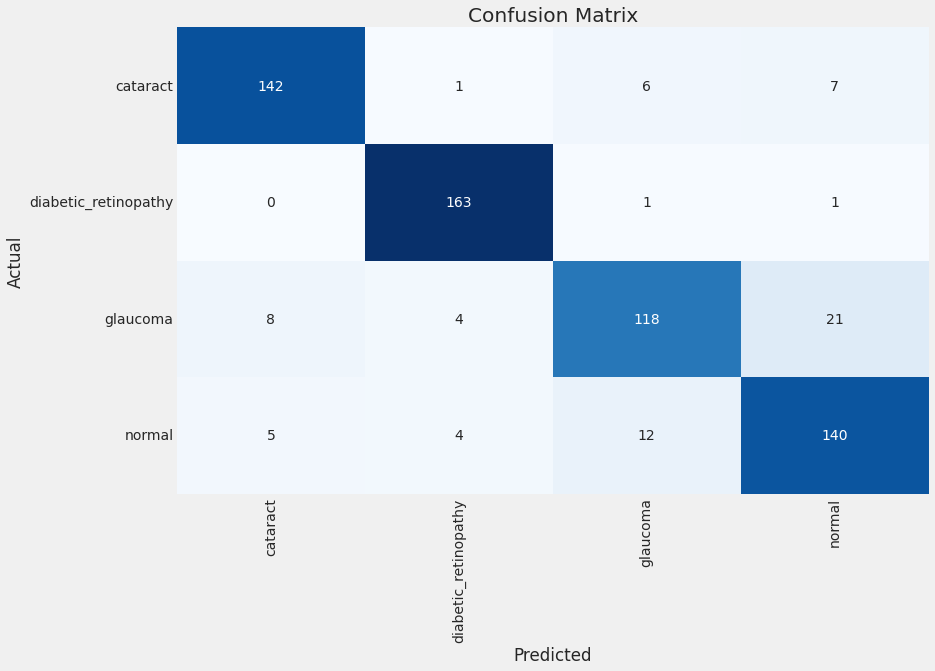

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9161    0.9103    0.9132       156
diabetic_retinopathy     0.9477    0.9879    0.9674       165
            glaucoma     0.8613    0.7815    0.8194       151
              normal     0.8284    0.8696    0.8485       161

            accuracy                         0.8894       633
           macro avg     0.8884    0.8873    0.8871       633
        weighted avg     0.8890    0.8894    0.8885       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.91025641 0.98787879 0.78145695 0.86956522]
88.84881622124568


In [22]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'vgg19adamax.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

### Transfer Learning

In [23]:
def make_model_trans(img_size, lr, mod_num=3, optimizer_mode=2):  # using B3 model by default
    img_shape=(img_size[0], img_size[1], 3)                       # using Adam as default optimizer
    if mod_num == 0:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created VGG19 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'  
    else:
        base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created ResNet50 model'   
   
    base_model.trainable=False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    if optimizer_mode == 1:
        model.compile(SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with SGD optimizer'
    if optimizer_mode == 2:
        model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adam optimizer'
    if optimizer_mode == 3:
        model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adamax optimizer' 
    
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    model.summary()
    return model

lr=.001

#### *VGG19* Optimizer: Adam

In [18]:
model=make_model_trans(img_size, lr, mod_num=0)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created VGG19 model with Adam optimizer with initial learning rate set to 0.001

Model: "model_3"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_4 (InputLayer)         [(None, 224, 224, 3)]     0         

_________________________________________________________________

block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      

_________________________________________________________________

block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     

_________________________________________________________________

block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         

_________________________________________________________________

block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     

_________________________________________________________________

block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    

_____________________________

 H


you entered H,  Training halted on epoch 5 due to user input



loading model with weights from epoch 5

training elapsed time was 0.0 hours,  2.0 minutes, 8.16 seconds)


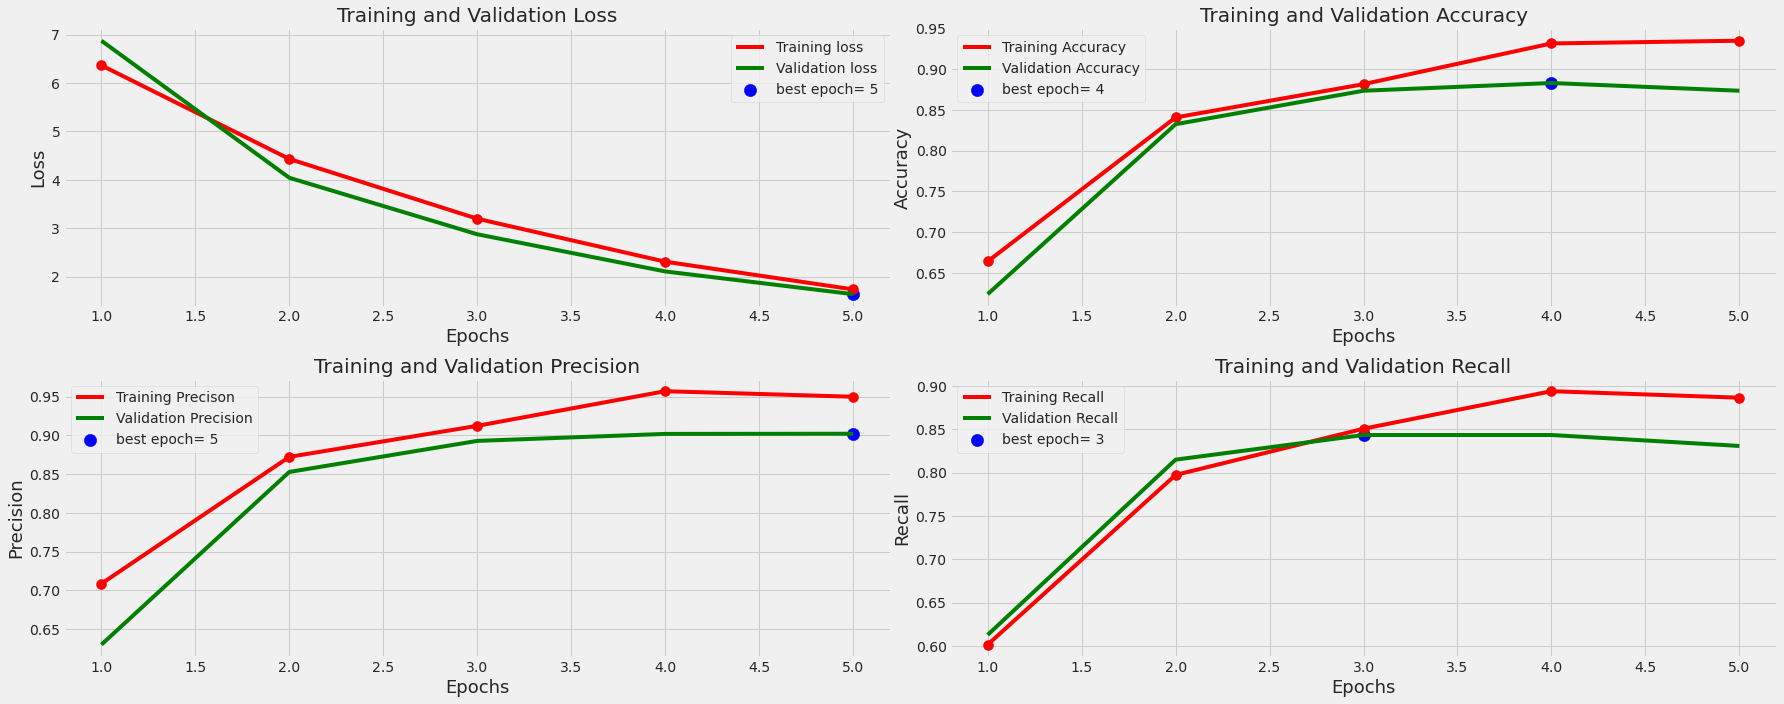

4

211/211 [==============================] - 6s 28ms/step

there were 95 errors in 633 tests for an accuracy of  84.99


<Figure size 432x288 with 0 Axes>

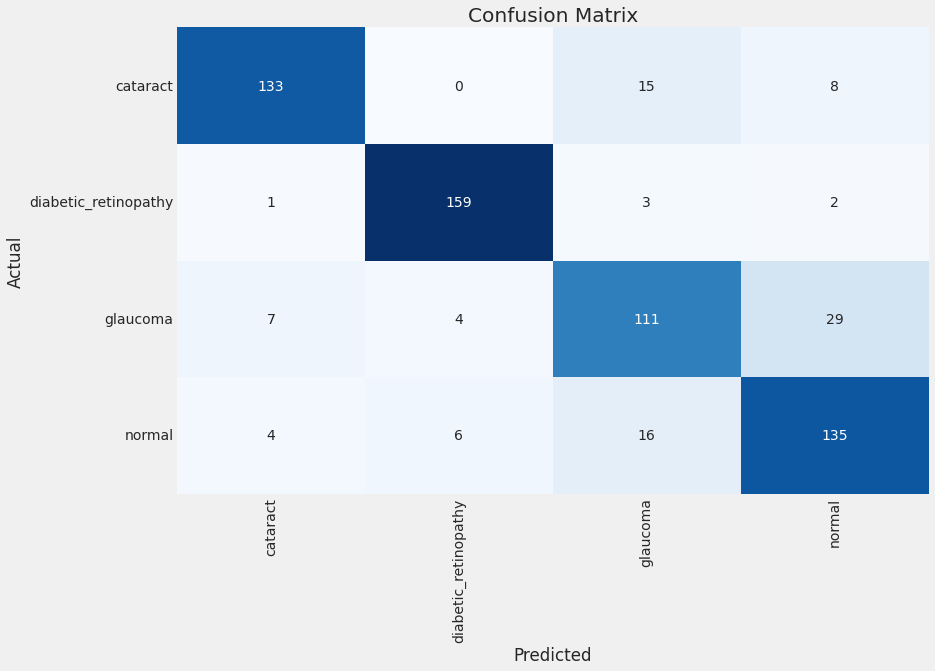

Classification Report:

----------------------

                       precision    recall  f1-score   support



            cataract     0.9172    0.8526    0.8837       156

diabetic_retinopathy     0.9408    0.9636    0.9521       165

            glaucoma     0.7655    0.7351    0.7500       151

              normal     0.7759    0.8385    0.8060       161



            accuracy                         0.8499       633

           macro avg     0.8499    0.8475    0.8479       633

        weighted avg     0.8512    0.8499    0.8499       633



Accuracy for classes in order C, D, G, N:

----------------------

 [0.8525641  0.96363636 0.73509934 0.83850932]

84.98696169500212


In [19]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transvgg19.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *VGG19* Optimizer: Adamax

In [20]:
model=make_model_trans(img_size, lr, mod_num=0, optimizer_mode=3)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created VGG19 model with Adamax optimizer with initial learning rate set to 0.001

Model: "model_4"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_5 (InputLayer)         [(None, 224, 224, 3)]     0         

_________________________________________________________________

block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      

_________________________________________________________________

block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     

_________________________________________________________________

block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         

_________________________________________________________________

block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     

_________________________________________________________________

block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    

___________________________

 3


you entered 3 Training will continue to epoch 8

Epoch 6/40

40/40 [==============================] - 18s 451ms/step - loss: 3.7976 - accuracy: 0.8708 - precision: 0.9116 - recall: 0.8333 - val_loss: 3.7164 - val_accuracy: 0.8436 - val_precision: 0.8862 - val_recall: 0.8120



 validation loss of  3.7164 is  8.6472 % below lowest loss, saving weights from epoch 6   as best weights

Epoch 7/40

40/40 [==============================] - 18s 462ms/step - loss: 3.4438 - accuracy: 0.8900 - precision: 0.9188 - recall: 0.8483 - val_loss: 3.3931 - val_accuracy: 0.8594 - val_precision: 0.8883 - val_recall: 0.8167



 validation loss of  3.3931 is  8.6989 % below lowest loss, saving weights from epoch 7   as best weights

Epoch 8/40

40/40 [==============================] - 18s 459ms/step - loss: 3.1316 - accuracy: 0.9058 - precision: 0.9346 - recall: 0.8692 - val_loss: 3.1045 - val_accuracy: 0.8594 - val_precision: 0.8853 - val_recall: 0.8167



 validation loss of  3.1045 is  8.5071 % below low

 H


you entered H,  Training halted on epoch 8 due to user input



loading model with weights from epoch 8

training elapsed time was 0.0 hours,  2.0 minutes, 36.45 seconds)


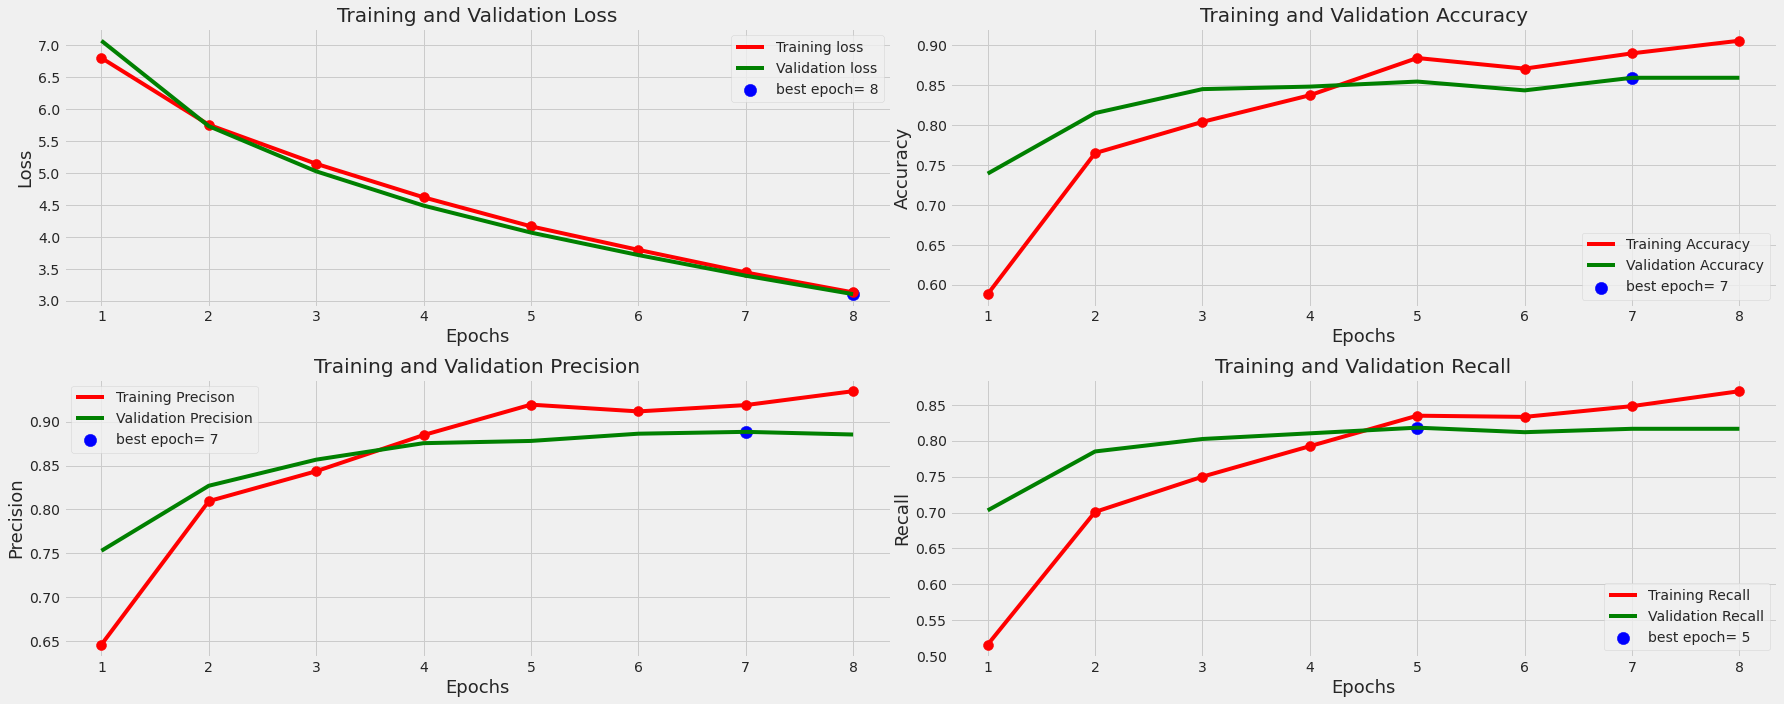

7

211/211 [==============================] - 6s 29ms/step

there were 96 errors in 633 tests for an accuracy of  84.83


<Figure size 432x288 with 0 Axes>

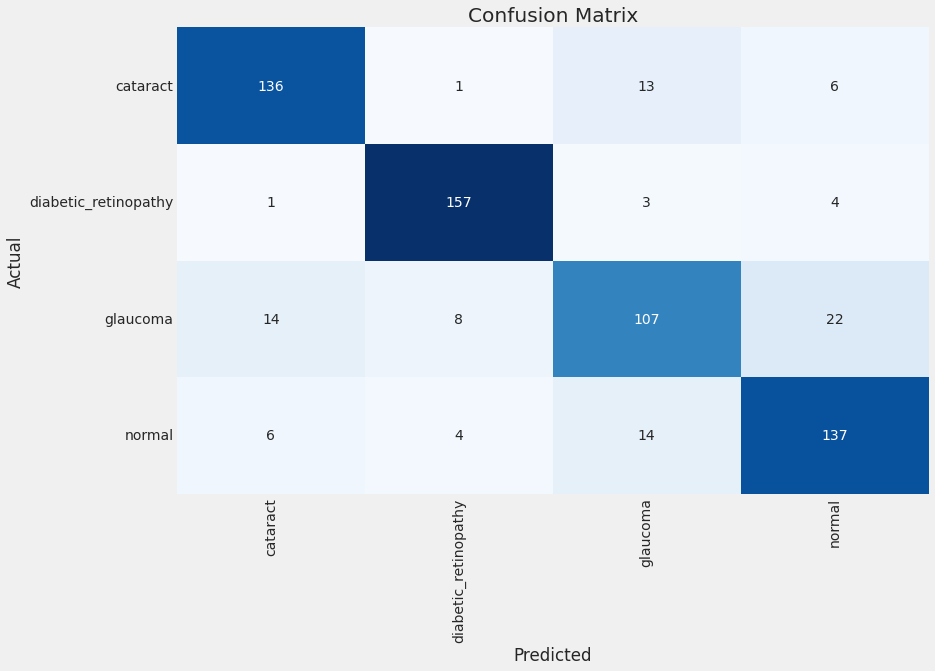

Classification Report:

----------------------

                       precision    recall  f1-score   support



            cataract     0.8662    0.8718    0.8690       156

diabetic_retinopathy     0.9235    0.9515    0.9373       165

            glaucoma     0.7810    0.7086    0.7431       151

              normal     0.8107    0.8509    0.8303       161



            accuracy                         0.8483       633

           macro avg     0.8454    0.8457    0.8449       633

        weighted avg     0.8467    0.8483    0.8469       633



Accuracy for classes in order C, D, G, N:

----------------------

 [0.87179487 0.95151515 0.70860927 0.85093168]

84.69232044127251


In [21]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transvgg19.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *ResNet50* Optimizer: SGD

In [24]:
model=make_model_trans(img_size, lr, mod_num=7, optimizer_mode=1)
# instantiate custom callback
epochs=50
ask_epoch=20
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

94781440/94765736 [==============================] - 0s 0us/step
Created ResNet50 model with SGD optimizer with initial learning rate set to 0.001
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 

 10


you entered 10 Training will continue to epoch 30
Epoch 21/50
94/94 [==============================] - 34s 362ms/step - loss: 7.4468 - accuracy: 0.8589 - precision: 0.8825 - recall: 0.8396 - val_loss: 7.3737 - val_accuracy: 0.8973 - val_precision: 0.9148 - val_recall: 0.8815

 validation loss of  7.3737 is  0.6497 % below lowest loss, saving weights from epoch 21  as best weights
Epoch 22/50
94/94 [==============================] - 34s 366ms/step - loss: 7.3840 - accuracy: 0.8693 - precision: 0.8883 - recall: 0.8464 - val_loss: 7.3265 - val_accuracy: 0.8973 - val_precision: 0.9165 - val_recall: 0.8847

 validation loss of  7.3265 is  0.6404 % below lowest loss, saving weights from epoch 22  as best weights
Epoch 23/50
94/94 [==============================] - 34s 364ms/step - loss: 7.3302 - accuracy: 0.8743 - precision: 0.8963 - recall: 0.8518 - val_loss: 7.2784 - val_accuracy: 0.8973 - val_precision: 0.9184 - val_recall: 0.8894

 validation loss of  7.2784 is  0.6555 % below lowest los

 H


you entered H,  Training halted on epoch 30 due to user input

loading model with weights from epoch 30
training elapsed time was 0.0 hours, 18.0 minutes, 0.96 seconds)


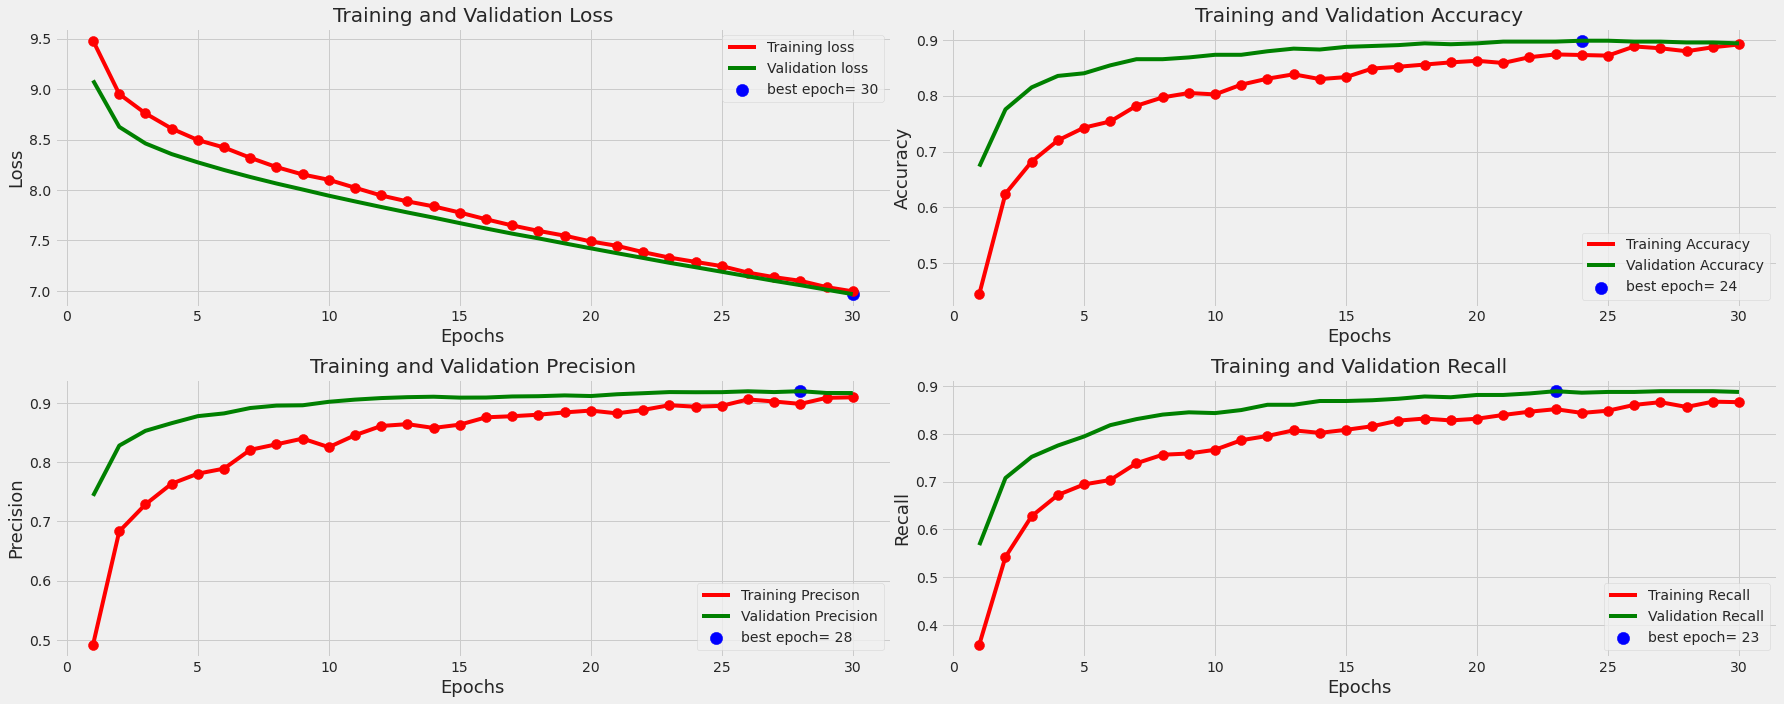

29
211/211 [==============================] - 8s 32ms/step
there were 83 errors in 633 tests for an accuracy of  86.89


<Figure size 432x288 with 0 Axes>

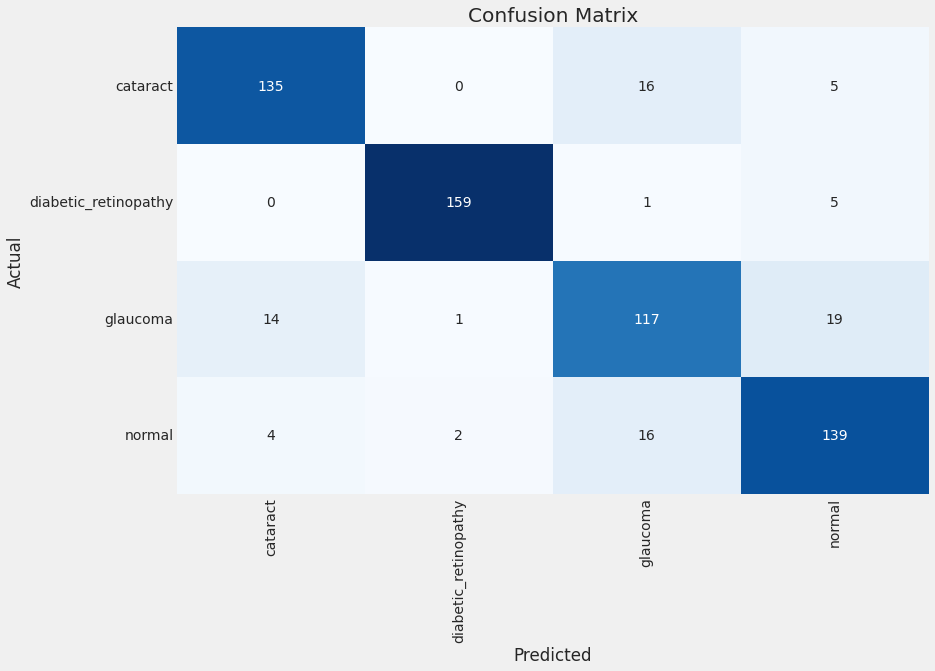

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.8824    0.8654    0.8738       156
diabetic_retinopathy     0.9815    0.9636    0.9725       165
            glaucoma     0.7800    0.7748    0.7774       151
              normal     0.8274    0.8634    0.8450       161

            accuracy                         0.8689       633
           macro avg     0.8678    0.8668    0.8672       633
        weighted avg     0.8698    0.8689    0.8692       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.86538462 0.96363636 0.77483444 0.86335404]
86.91953439469306


In [25]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transResNet.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *ResNet50* Optimizer: Adam

In [26]:
model=make_model_trans(img_size, lr, mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created ResNet50 model with Adam optimizer with initial learning rate set to 0.001
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________

 3


you entered 3 Training will continue to epoch 8
Epoch 6/40
94/94 [==============================] - 35s 367ms/step - loss: 0.8271 - accuracy: 0.9168 - precision: 0.9281 - recall: 0.8939 - val_loss: 0.7922 - val_accuracy: 0.9005 - val_precision: 0.9180 - val_recall: 0.8847

 validation loss of  0.7922 is  6.4283 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 34s 365ms/step - loss: 0.7434 - accuracy: 0.9189 - precision: 0.9345 - recall: 0.8971 - val_loss: 0.7309 - val_accuracy: 0.9179 - val_precision: 0.9299 - val_recall: 0.9005

 validation loss of  0.7309 is  7.7275 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 34s 362ms/step - loss: 0.7343 - accuracy: 0.9129 - precision: 0.9294 - recall: 0.8936 - val_loss: 0.7524 - val_accuracy: 0.8942 - val_precision: 0.9083 - val_recall: 0.8768

 validation loss of  0.7524 is  2.9292 % above lowest loss of 

 2


you entered 2 Training will continue to epoch 10
Epoch 9/40
94/94 [==============================] - 35s 370ms/step - loss: 0.6127 - accuracy: 0.9500 - precision: 0.9621 - recall: 0.9332 - val_loss: 0.6044 - val_accuracy: 0.9084 - val_precision: 0.9233 - val_recall: 0.8942

 validation loss of  0.6044 is 17.3151 % below lowest loss, saving weights from epoch 9   as best weights
Epoch 10/40
94/94 [==============================] - 35s 370ms/step - loss: 0.5054 - accuracy: 0.9643 - precision: 0.9744 - recall: 0.9511 - val_loss: 0.5399 - val_accuracy: 0.9226 - val_precision: 0.9231 - val_recall: 0.9100

 validation loss of  0.5399 is 10.6625 % below lowest loss, saving weights from epoch 10  as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 3


you entered 3 Training will continue to epoch 13
Epoch 11/40
94/94 [==============================] - 34s 366ms/step - loss: 0.4485 - accuracy: 0.9675 - precision: 0.9780 - recall: 0.9507 - val_loss: 0.5115 - val_accuracy: 0.9273 - val_precision: 0.9339 - val_recall: 0.9147

 validation loss of  0.5115 is  5.2756 % below lowest loss, saving weights from epoch 11  as best weights
Epoch 12/40
94/94 [==============================] - 34s 363ms/step - loss: 0.4154 - accuracy: 0.9696 - precision: 0.9770 - recall: 0.9568 - val_loss: 0.5136 - val_accuracy: 0.9100 - val_precision: 0.9265 - val_recall: 0.8957

 validation loss of  0.5136 is  0.4158 % above lowest loss of  0.5115 keeping weights from epoch 11 as best weights
learning rate was automatically adjusted from 0.000400 to 0.000160, model weights set to best weights
Epoch 13/40
94/94 [==============================] - 34s 361ms/step - loss: 0.3995 - accuracy: 0.9779 - precision: 0.9836 - recall: 0.9650 - val_loss: 0.4794 - val_accuracy:

 H


you entered H,  Training halted on epoch 13 due to user input

loading model with weights from epoch 13
training elapsed time was 0.0 hours, 10.0 minutes, 24.15 seconds)


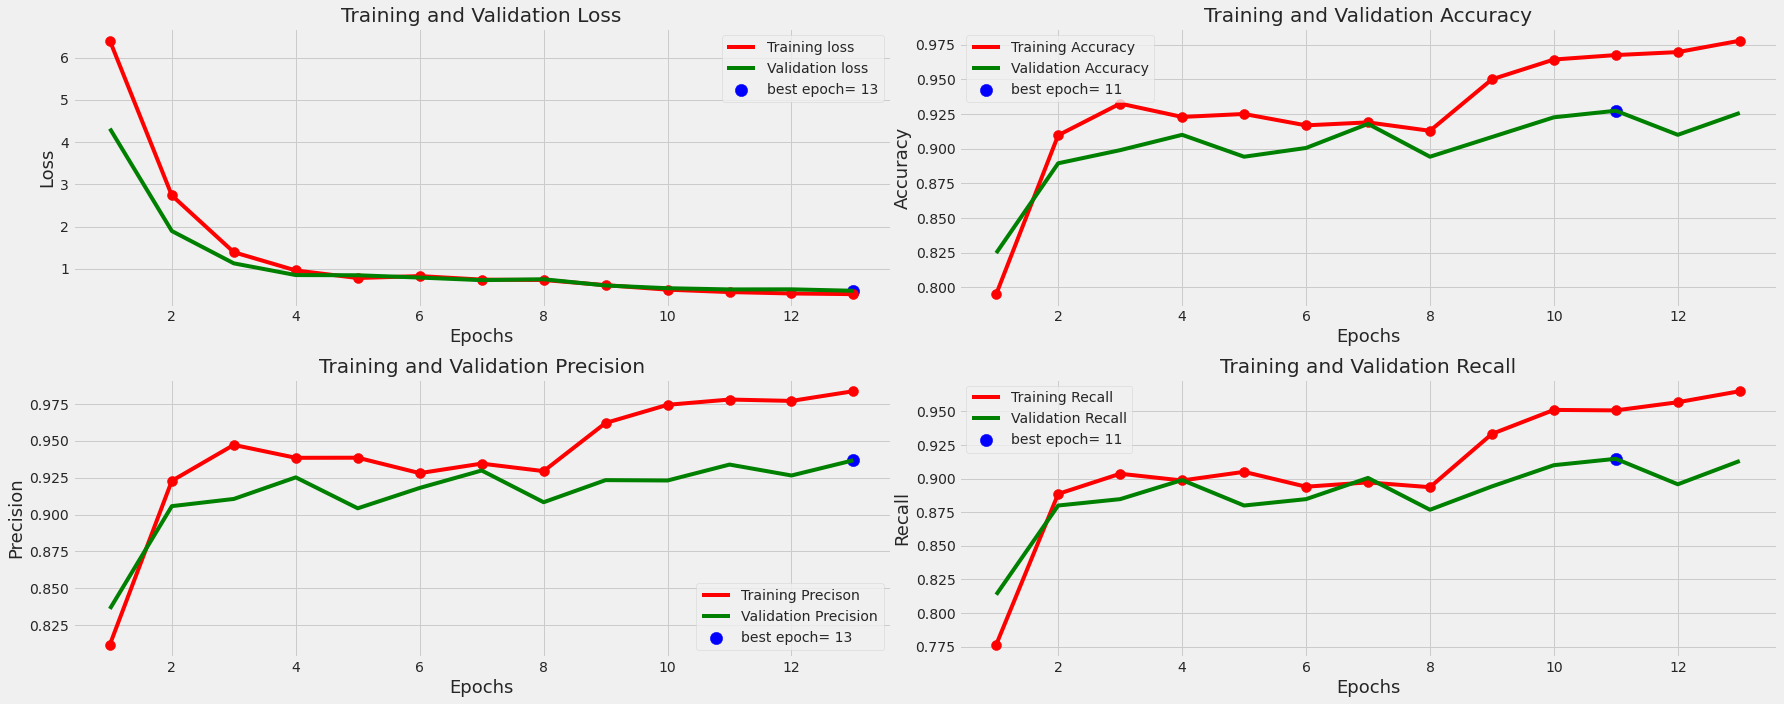

12
211/211 [==============================] - 8s 34ms/step
there were 67 errors in 633 tests for an accuracy of  89.42


<Figure size 432x288 with 0 Axes>

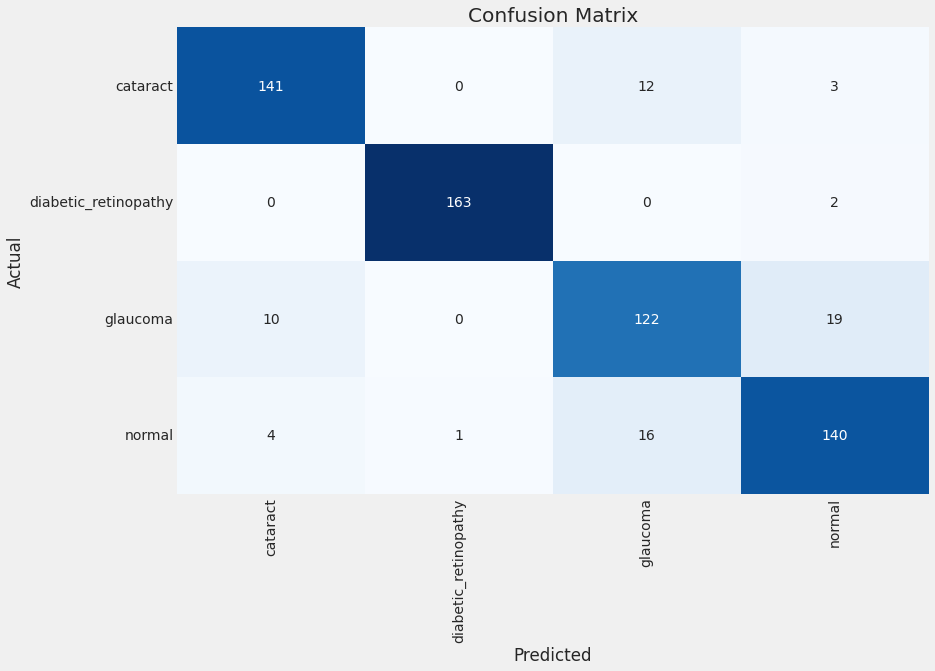

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9097    0.9038    0.9068       156
diabetic_retinopathy     0.9939    0.9879    0.9909       165
            glaucoma     0.8133    0.8079    0.8106       151
              normal     0.8537    0.8696    0.8615       161

            accuracy                         0.8942       633
           macro avg     0.8926    0.8923    0.8925       633
        weighted avg     0.8944    0.8942    0.8943       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.90384615 0.98787879 0.80794702 0.86956522]
89.42524879266688


In [27]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transResNet.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *ResNet50* Optimizer: Adamax

In [28]:
model=make_model_trans(img_size, lr, mod_num=7, optimizer_mode=3)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created ResNet50 model with Adamax optimizer with initial learning rate set to 0.001
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______

 H


you entered H,  Training halted on epoch 5 due to user input

loading model with weights from epoch 5
training elapsed time was 0.0 hours,  3.0 minutes, 7.15 seconds)


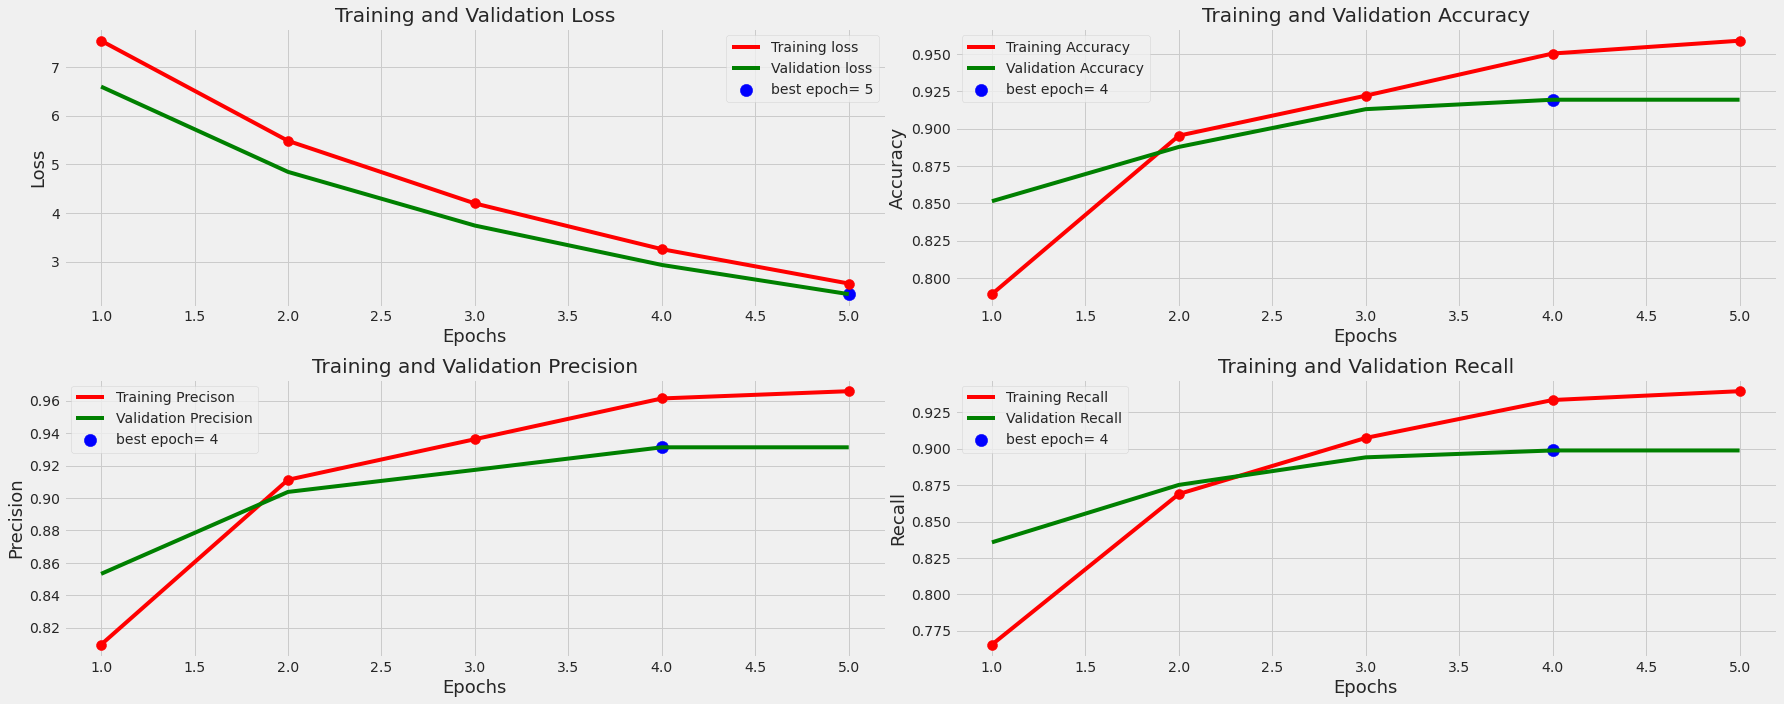

4
211/211 [==============================] - 7s 30ms/step
there were 66 errors in 633 tests for an accuracy of  89.57


<Figure size 432x288 with 0 Axes>

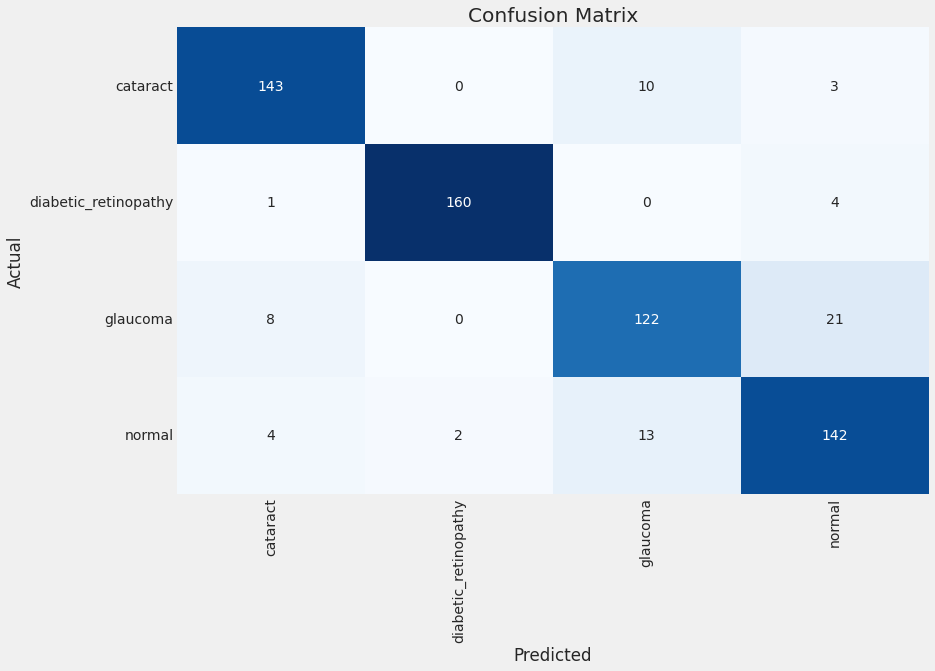

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9167    0.9167    0.9167       156
diabetic_retinopathy     0.9877    0.9697    0.9786       165
            glaucoma     0.8414    0.8079    0.8243       151
              normal     0.8353    0.8820    0.8580       161

            accuracy                         0.8957       633
           macro avg     0.8952    0.8941    0.8944       633
        weighted avg     0.8965    0.8957    0.8959       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.91666667 0.96969697 0.80794702 0.88198758]
89.58607198908334


In [29]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transResNet.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3* Optimizer: SGD

In [30]:
model=make_model_trans(img_size, lr,optimizer_mode=1)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

43950080/43941136 [==============================] - 0s 0us/step
Created EfficientNet B3 model with SGD optimizer with initial learning rate set to 0.001
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None

 15


you entered 15 Training will continue to epoch 20
Epoch 6/40
94/94 [==============================] - 35s 370ms/step - loss: 8.4281 - accuracy: 0.6646 - precision: 0.7005 - recall: 0.5964 - val_loss: 7.9708 - val_accuracy: 0.8136 - val_precision: 0.8519 - val_recall: 0.7362

 validation loss of  7.9708 is  1.0007 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 35s 374ms/step - loss: 8.2950 - accuracy: 0.6839 - precision: 0.7259 - recall: 0.6243 - val_loss: 7.9030 - val_accuracy: 0.8246 - val_precision: 0.8595 - val_recall: 0.7536

 validation loss of  7.9030 is  0.8506 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 36s 381ms/step - loss: 8.2207 - accuracy: 0.6896 - precision: 0.7330 - recall: 0.6325 - val_loss: 7.8341 - val_accuracy: 0.8215 - val_precision: 0.8627 - val_recall: 0.7646

 validation loss of  7.8341 is  0.8714 % below lowest loss, 

 10


you entered 10 Training will continue to epoch 30
Epoch 21/40
94/94 [==============================] - 35s 371ms/step - loss: 7.3960 - accuracy: 0.7761 - precision: 0.8148 - recall: 0.7289 - val_loss: 7.1408 - val_accuracy: 0.8594 - val_precision: 0.8959 - val_recall: 0.8294

 validation loss of  7.1408 is  0.6541 % below lowest loss, saving weights from epoch 21  as best weights
Epoch 22/40
94/94 [==============================] - 35s 375ms/step - loss: 7.3410 - accuracy: 0.7814 - precision: 0.8131 - recall: 0.7332 - val_loss: 7.0955 - val_accuracy: 0.8657 - val_precision: 0.8980 - val_recall: 0.8341

 validation loss of  7.0955 is  0.6350 % below lowest loss, saving weights from epoch 22  as best weights
Epoch 23/40
94/94 [==============================] - 35s 370ms/step - loss: 7.2845 - accuracy: 0.7796 - precision: 0.8165 - recall: 0.7404 - val_loss: 7.0492 - val_accuracy: 0.8673 - val_precision: 0.8983 - val_recall: 0.8373

 validation loss of  7.0492 is  0.6519 % below lowest los

 H


you entered H,  Training halted on epoch 30 due to user input

loading model with weights from epoch 30
training elapsed time was 0.0 hours, 18.0 minutes, 21.74 seconds)


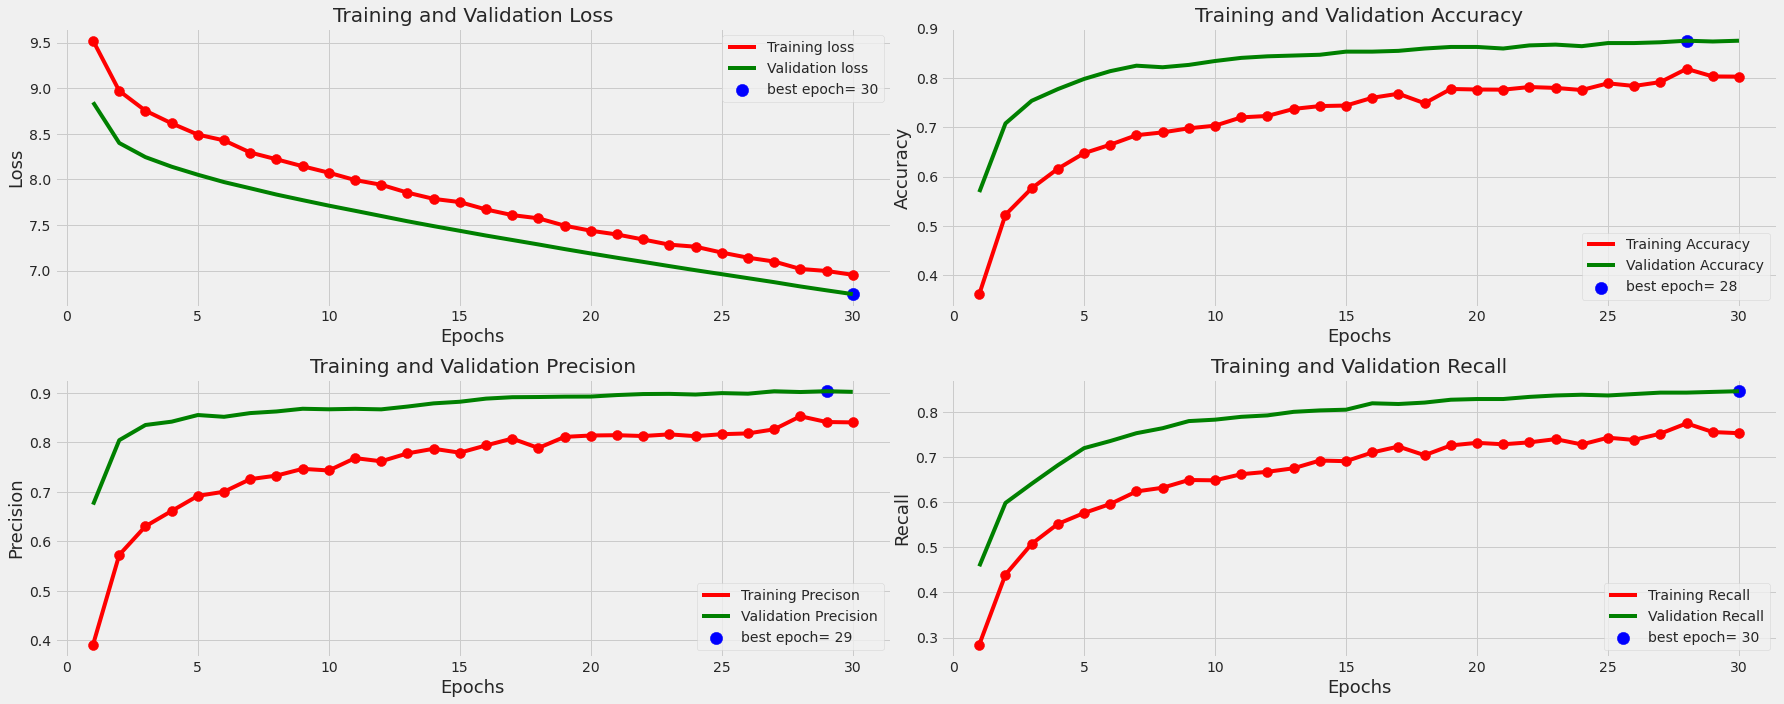

29
211/211 [==============================] - 10s 40ms/step
there were 100 errors in 633 tests for an accuracy of  84.20


<Figure size 432x288 with 0 Axes>

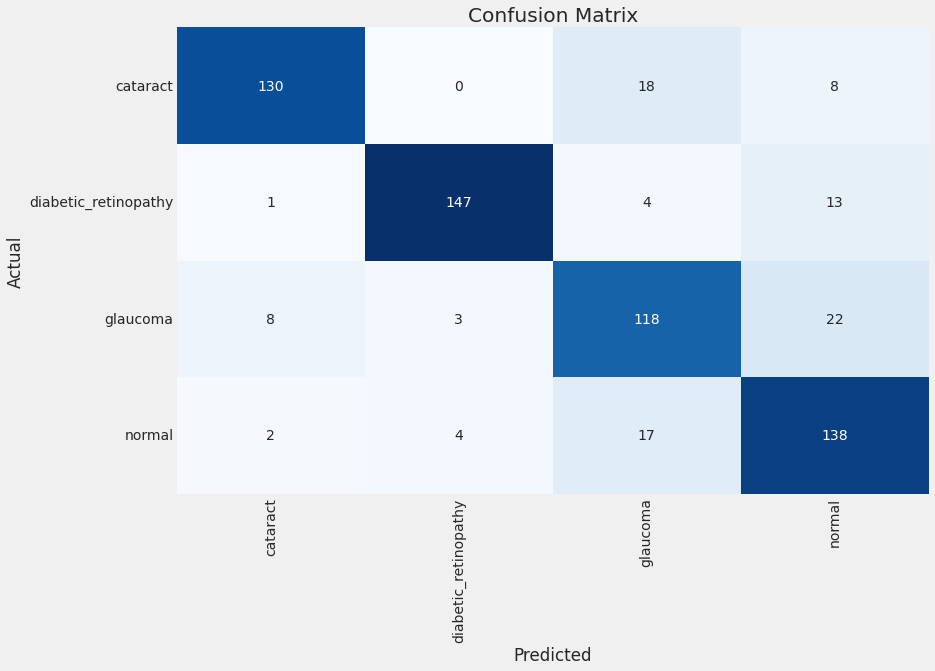

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9220    0.8333    0.8754       156
diabetic_retinopathy     0.9545    0.8909    0.9216       165
            glaucoma     0.7516    0.7815    0.7662       151
              normal     0.7624    0.8571    0.8070       161

            accuracy                         0.8420       633
           macro avg     0.8476    0.8407    0.8426       633
        weighted avg     0.8492    0.8420    0.8440       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.83333333 0.89090909 0.78145695 0.85714286]
84.40217146060034


In [31]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3* Optimizer: Adam

In [32]:
model=make_model_trans(img_size, lr)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adam optimizer with initial learning rate set to 0.001
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
__

 5


you entered 5 Training will continue to epoch 10
Epoch 6/40
94/94 [==============================] - 35s 372ms/step - loss: 1.0160 - accuracy: 0.8504 - precision: 0.8842 - recall: 0.8071 - val_loss: 0.8435 - val_accuracy: 0.8942 - val_precision: 0.9156 - val_recall: 0.8736

 validation loss of  0.8435 is 10.7426 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 35s 371ms/step - loss: 0.9753 - accuracy: 0.8400 - precision: 0.8703 - recall: 0.7936 - val_loss: 0.8379 - val_accuracy: 0.8942 - val_precision: 0.9126 - val_recall: 0.8578

 validation loss of  0.8379 is  0.6688 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 35s 376ms/step - loss: 0.9414 - accuracy: 0.8475 - precision: 0.8807 - recall: 0.8018 - val_loss: 0.7911 - val_accuracy: 0.8989 - val_precision: 0.9203 - val_recall: 0.8752

 validation loss of  0.7911 is  5.5871 % below lowest loss, s

 2


you entered 2 Training will continue to epoch 12
Epoch 11/40
94/94 [==============================] - 35s 374ms/step - loss: 0.6992 - accuracy: 0.8936 - precision: 0.9283 - recall: 0.8504 - val_loss: 0.6336 - val_accuracy: 0.8942 - val_precision: 0.9221 - val_recall: 0.8784

 validation loss of  0.6336 is  6.6970 % below lowest loss, saving weights from epoch 11  as best weights
Epoch 12/40
94/94 [==============================] - 35s 372ms/step - loss: 0.6515 - accuracy: 0.8921 - precision: 0.9227 - recall: 0.8489 - val_loss: 0.6026 - val_accuracy: 0.9005 - val_precision: 0.9195 - val_recall: 0.8847

 validation loss of  0.6026 is  4.8800 % below lowest loss, saving weights from epoch 12  as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 H


you entered H,  Training halted on epoch 12 due to user input

loading model with weights from epoch 12
training elapsed time was 0.0 hours,  7.0 minutes, 29.06 seconds)


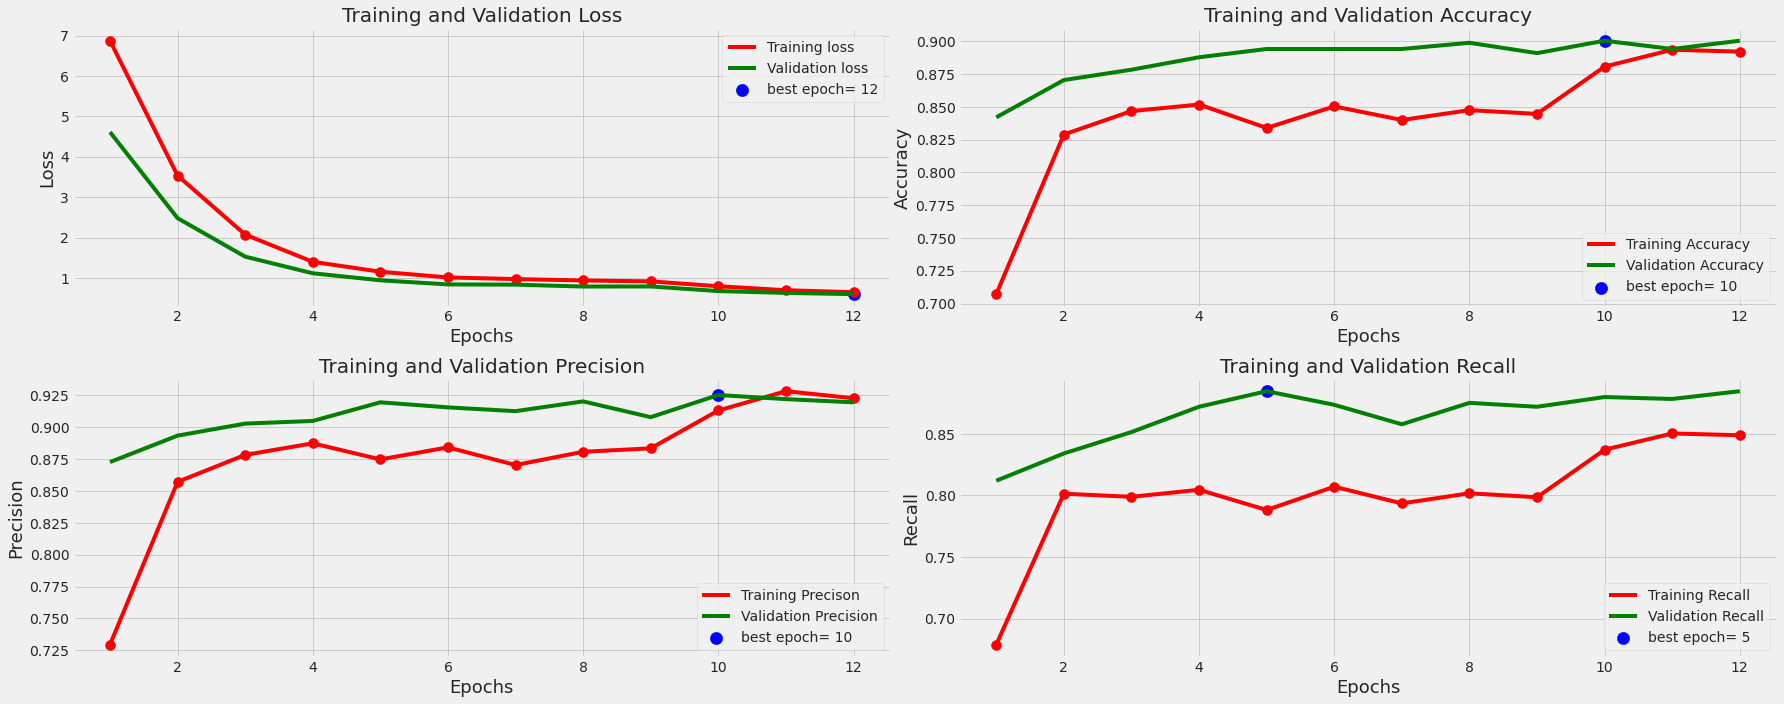

11
211/211 [==============================] - 11s 41ms/step
there were 63 errors in 633 tests for an accuracy of  90.05


<Figure size 432x288 with 0 Axes>

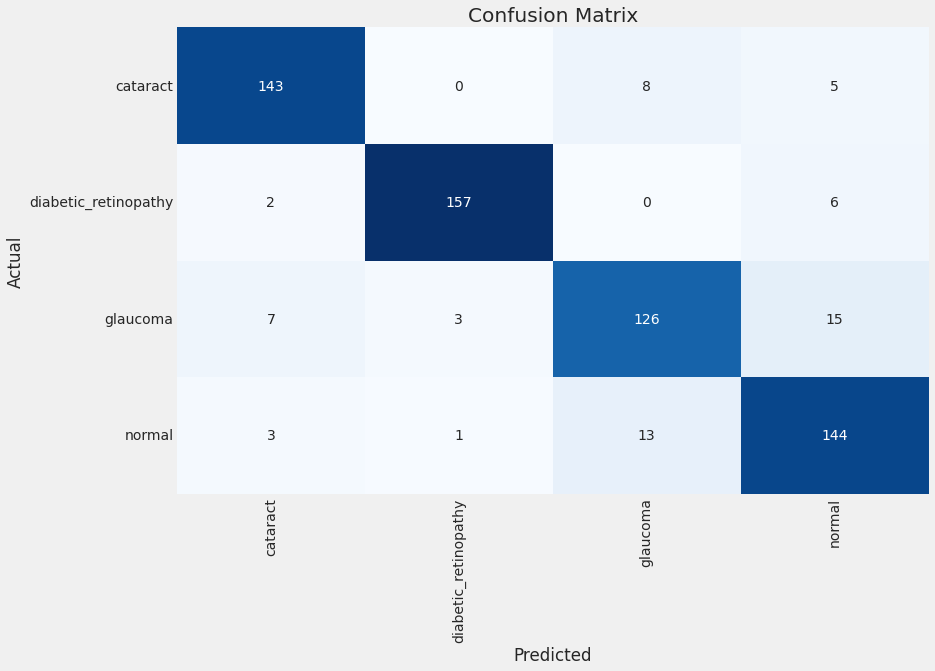

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9226    0.9167    0.9196       156
diabetic_retinopathy     0.9752    0.9515    0.9632       165
            glaucoma     0.8571    0.8344    0.8456       151
              normal     0.8471    0.8944    0.8701       161

            accuracy                         0.9005       633
           macro avg     0.9005    0.8993    0.8996       633
        weighted avg     0.9015    0.9005    0.9007       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.91666667 0.95151515 0.83443709 0.89440994]
90.07299443204636


In [33]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3* Optimizer: Adamax

In [34]:
model=make_model_trans(img_size, lr, optimizer_mode=3)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adamax optimizer with initial learning rate set to 0.001
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            


 5


you entered 5 Training will continue to epoch 10
Epoch 6/40
94/94 [==============================] - 35s 376ms/step - loss: 2.5689 - accuracy: 0.8850 - precision: 0.9138 - recall: 0.8439 - val_loss: 2.2714 - val_accuracy: 0.8942 - val_precision: 0.9215 - val_recall: 0.8720

 validation loss of  2.2714 is 17.1963 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 35s 367ms/step - loss: 2.1283 - accuracy: 0.8993 - precision: 0.9249 - recall: 0.8575 - val_loss: 1.8923 - val_accuracy: 0.9021 - val_precision: 0.9203 - val_recall: 0.8752

 validation loss of  1.8923 is 16.6931 % below lowest loss, saving weights from epoch 7   as best weights
Epoch 8/40
94/94 [==============================] - 35s 372ms/step - loss: 1.7905 - accuracy: 0.8914 - precision: 0.9229 - recall: 0.8461 - val_loss: 1.5977 - val_accuracy: 0.8973 - val_precision: 0.9246 - val_recall: 0.8720

 validation loss of  1.5977 is 15.5661 % below lowest loss, s

 2


you entered 2 Training will continue to epoch 12
Epoch 11/40
94/94 [==============================] - 35s 366ms/step - loss: 1.1471 - accuracy: 0.9036 - precision: 0.9311 - recall: 0.8636 - val_loss: 1.0456 - val_accuracy: 0.9021 - val_precision: 0.9213 - val_recall: 0.8878

 validation loss of  1.0456 is 11.3149 % below lowest loss, saving weights from epoch 11  as best weights
Epoch 12/40
94/94 [==============================] - 35s 373ms/step - loss: 1.0139 - accuracy: 0.9075 - precision: 0.9328 - recall: 0.8682 - val_loss: 0.9422 - val_accuracy: 0.9084 - val_precision: 0.9285 - val_recall: 0.8815

 validation loss of  0.9422 is  9.8896 % below lowest loss, saving weights from epoch 12  as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 H


you entered H,  Training halted on epoch 12 due to user input

loading model with weights from epoch 12
training elapsed time was 0.0 hours,  7.0 minutes, 28.55 seconds)


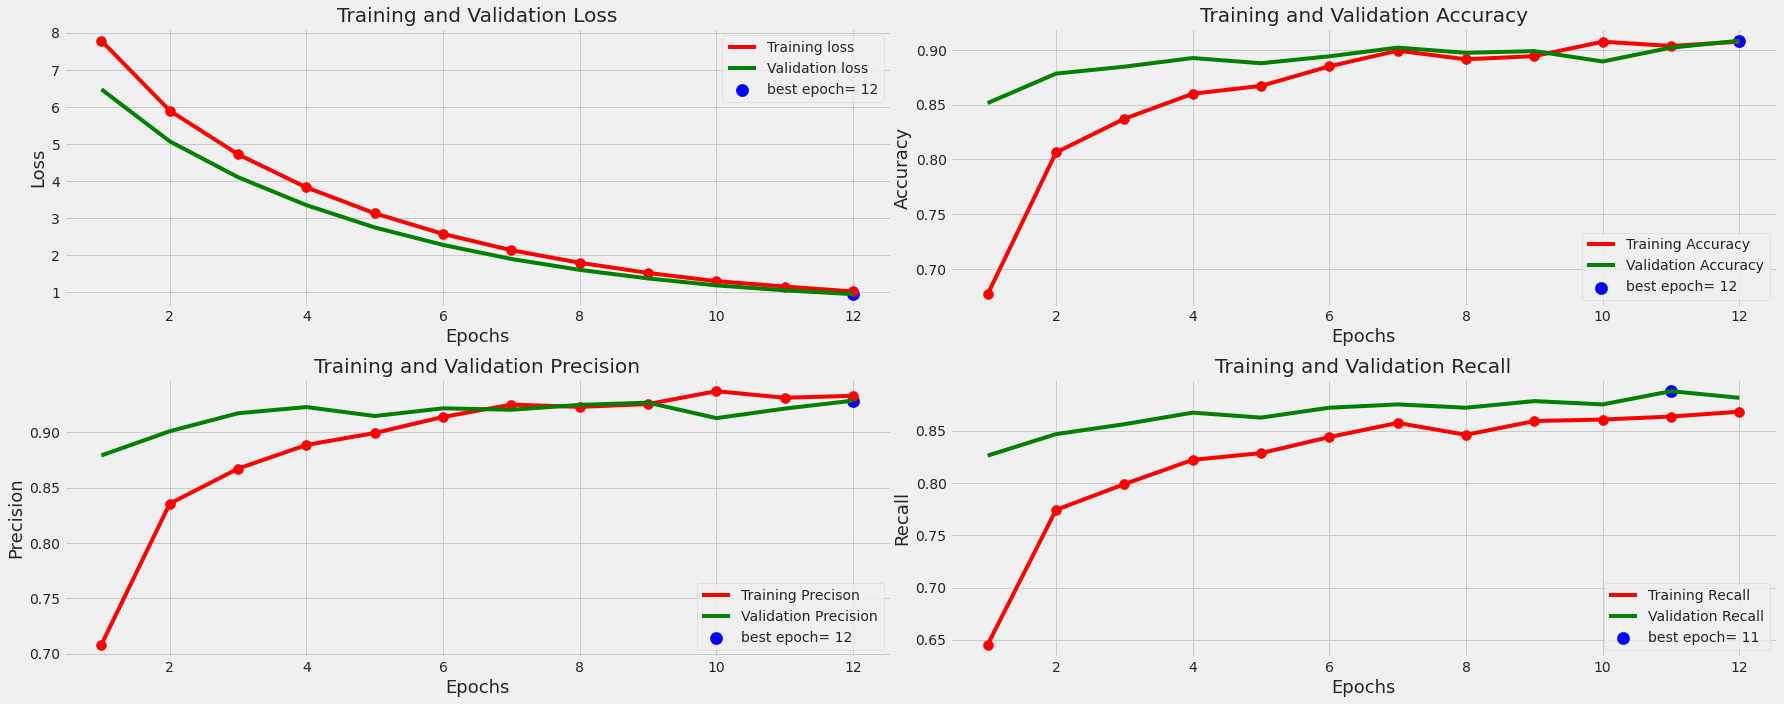

11
211/211 [==============================] - 10s 40ms/step
there were 67 errors in 633 tests for an accuracy of  89.42


<Figure size 432x288 with 0 Axes>

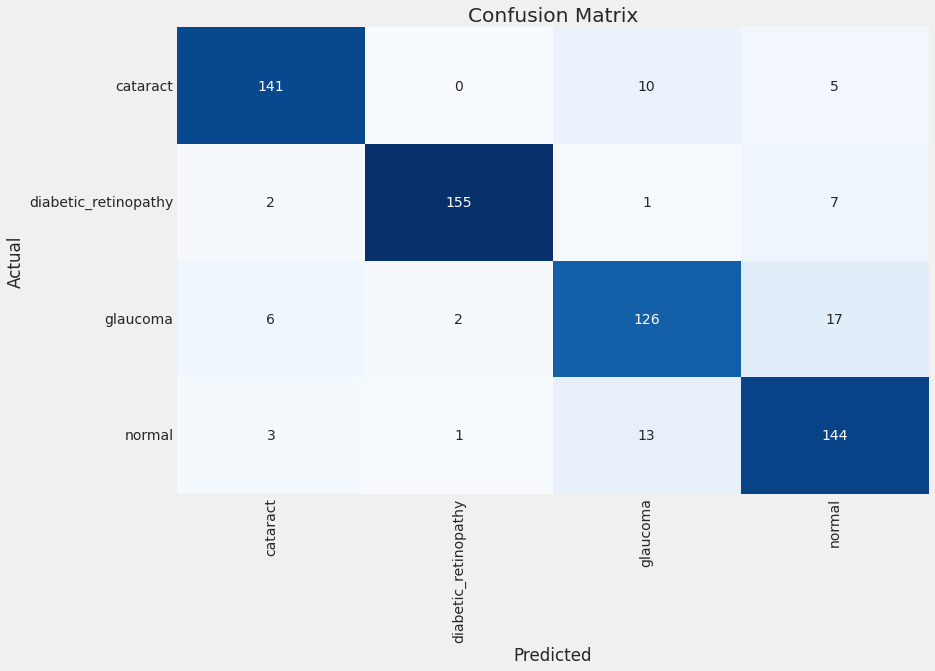

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9276    0.9038    0.9156       156
diabetic_retinopathy     0.9810    0.9394    0.9598       165
            glaucoma     0.8400    0.8344    0.8372       151
              normal     0.8324    0.8944    0.8623       161

            accuracy                         0.8942       633
           macro avg     0.8953    0.8930    0.8937       633
        weighted avg     0.8964    0.8942    0.8948       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.90384615 0.93939394 0.83443709 0.89440994]
89.48424232459018


In [35]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'transEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

### Fine Tuning

In [36]:
def make_model_finetune(img_size, lr, mod_num=3, optimizer_mode=2):  # using B3 model by default
    img_shape=(img_size[0], img_size[1], 3)                         # using Adam optimizer by default
    if mod_num == 0:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created VGG19 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created InceptionV3 model'
        
    else:
        base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created ResNet50 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    if optimizer_mode == 1:
        model.compile(SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with SGD optimizer'
    if optimizer_mode == 2:
        model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adam optimizer'
    if optimizer_mode == 3:
        model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adamax optimizer'

    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    model.summary()
    return model

lr=.001

#### *Efficient Net B3* SGD optimizer

In [46]:
model=make_model_finetune(img_size, lr, optimizer_mode=1)
# instantiate custom callback
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with SGD optimizer with initial learning rate set to 0.001
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
__

 10


you entered 10 Training will continue to epoch 20
Epoch 11/40
94/94 [==============================] - 62s 655ms/step - loss: 7.7326 - accuracy: 0.8407 - precision: 0.8625 - recall: 0.8157 - val_loss: 7.6516 - val_accuracy: 0.8768 - val_precision: 0.8940 - val_recall: 0.8657

 validation loss of  7.6516 is  0.8647 % below lowest loss, saving weights from epoch 11  as best weights
Epoch 12/40
94/94 [==============================] - 61s 643ms/step - loss: 7.6771 - accuracy: 0.8396 - precision: 0.8588 - recall: 0.8143 - val_loss: 7.5787 - val_accuracy: 0.8831 - val_precision: 0.8976 - val_recall: 0.8720

 validation loss of  7.5787 is  0.9524 % below lowest loss, saving weights from epoch 12  as best weights
Epoch 13/40
94/94 [==============================] - 61s 646ms/step - loss: 7.5861 - accuracy: 0.8518 - precision: 0.8742 - recall: 0.8318 - val_loss: 7.5252 - val_accuracy: 0.8784 - val_precision: 0.8935 - val_recall: 0.8752

 validation loss of  7.5252 is  0.7068 % below lowest los

 10


you entered 10 Training will continue to epoch 30
Epoch 21/40
94/94 [==============================] - 61s 645ms/step - loss: 7.1034 - accuracy: 0.8929 - precision: 0.9045 - recall: 0.8729 - val_loss: 7.1092 - val_accuracy: 0.9052 - val_precision: 0.9128 - val_recall: 0.8926

 validation loss of  7.1092 is  0.5814 % below lowest loss, saving weights from epoch 21  as best weights
Epoch 22/40
94/94 [==============================] - 61s 642ms/step - loss: 7.0542 - accuracy: 0.8964 - precision: 0.9114 - recall: 0.8779 - val_loss: 7.0927 - val_accuracy: 0.8942 - val_precision: 0.9063 - val_recall: 0.8863

 validation loss of  7.0927 is  0.2313 % below lowest loss, saving weights from epoch 22  as best weights
Epoch 23/40
94/94 [==============================] - 61s 643ms/step - loss: 7.0020 - accuracy: 0.9025 - precision: 0.9170 - recall: 0.8921 - val_loss: 7.0010 - val_accuracy: 0.9021 - val_precision: 0.9113 - val_recall: 0.8926

 validation loss of  7.0010 is  1.2927 % below lowest los

 10


you entered 10 Training will continue to epoch 40
Epoch 31/40
94/94 [==============================] - 61s 645ms/step - loss: 6.6009 - accuracy: 0.9225 - precision: 0.9336 - recall: 0.9089 - val_loss: 6.6336 - val_accuracy: 0.9100 - val_precision: 0.9206 - val_recall: 0.8973

 validation loss of  6.6336 is  0.5926 % below lowest loss, saving weights from epoch 31  as best weights
Epoch 32/40
94/94 [==============================] - 61s 644ms/step - loss: 6.5673 - accuracy: 0.9200 - precision: 0.9313 - recall: 0.9096 - val_loss: 6.5804 - val_accuracy: 0.9131 - val_precision: 0.9180 - val_recall: 0.9021

 validation loss of  6.5804 is  0.8027 % below lowest loss, saving weights from epoch 32  as best weights
Epoch 33/40
94/94 [==============================] - 61s 650ms/step - loss: 6.4966 - accuracy: 0.9282 - precision: 0.9399 - recall: 0.9157 - val_loss: 6.5293 - val_accuracy: 0.9210 - val_precision: 0.9254 - val_recall: 0.9021

 validation loss of  6.5293 is  0.7763 % below lowest los

 H


you entered H,  Training halted on epoch 40 due to user input

loading model with weights from epoch 40
training elapsed time was 0.0 hours, 50.0 minutes, 54.34 seconds)


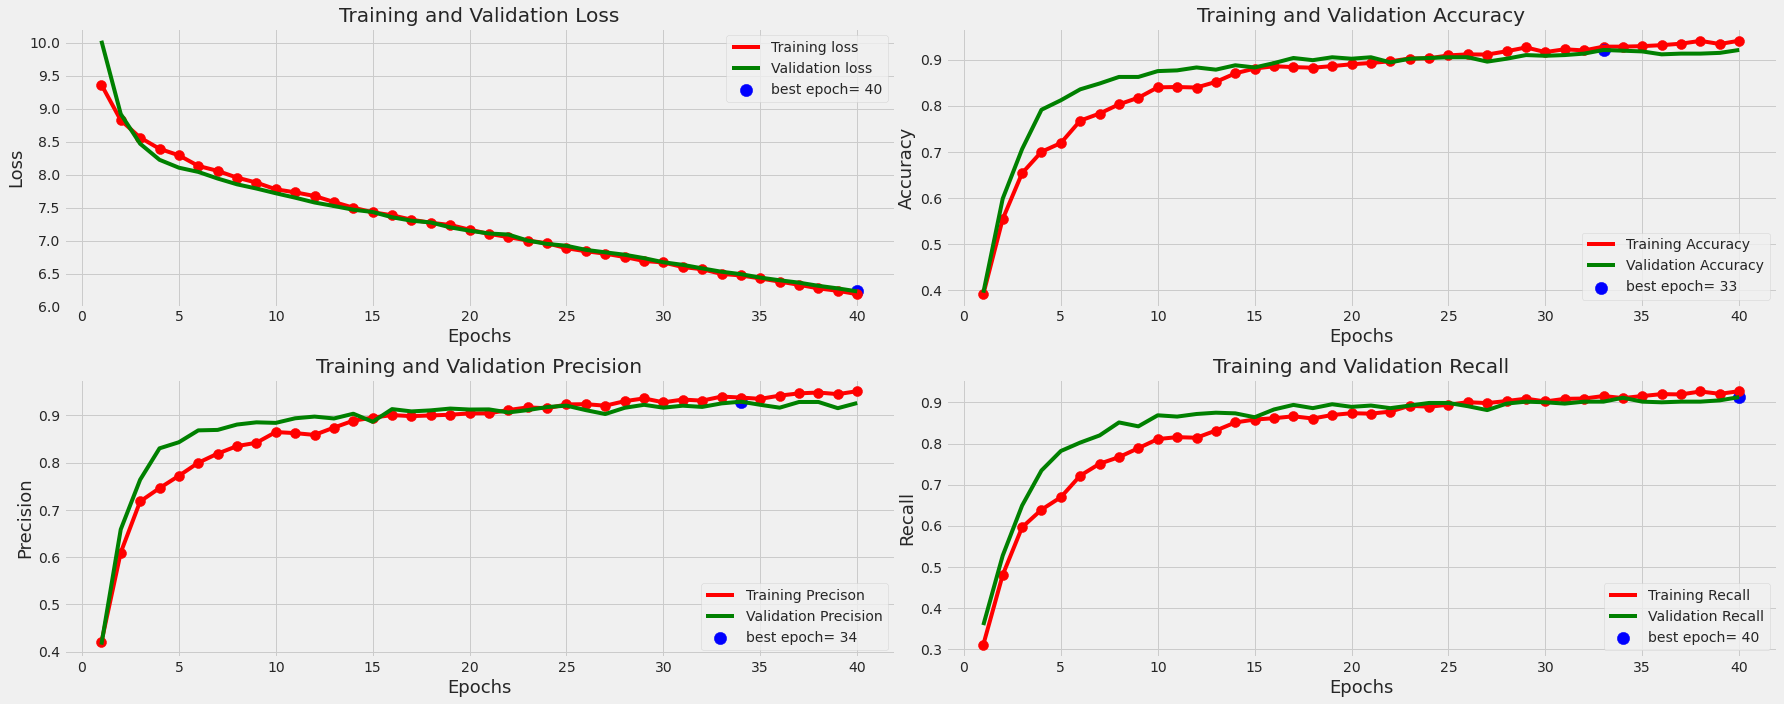

39
211/211 [==============================] - 11s 42ms/step
there were 65 errors in 633 tests for an accuracy of  89.73


<Figure size 432x288 with 0 Axes>

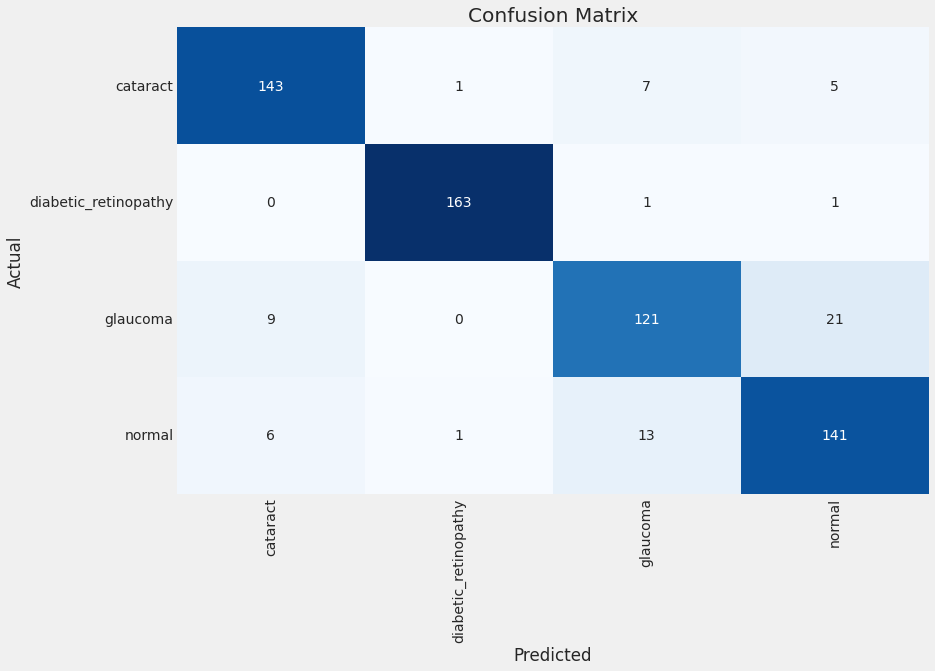

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9051    0.9167    0.9108       156
diabetic_retinopathy     0.9879    0.9879    0.9879       165
            glaucoma     0.8521    0.8013    0.8259       151
              normal     0.8393    0.8758    0.8571       161

            accuracy                         0.8973       633
           macro avg     0.8961    0.8954    0.8954       633
        weighted avg     0.8973    0.8973    0.8970       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.91666667 0.98787879 0.8013245  0.8757764 ]
89.7007733845198


In [47]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3* Adam optimizer

In [37]:
model=make_model_finetune(img_size, lr)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adam optimizer with initial learning rate set to 0.001
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
__

 H


you entered H,  Training halted on epoch 5 due to user input

loading model with weights from epoch 5
training elapsed time was 0.0 hours,  6.0 minutes, 46.57 seconds)


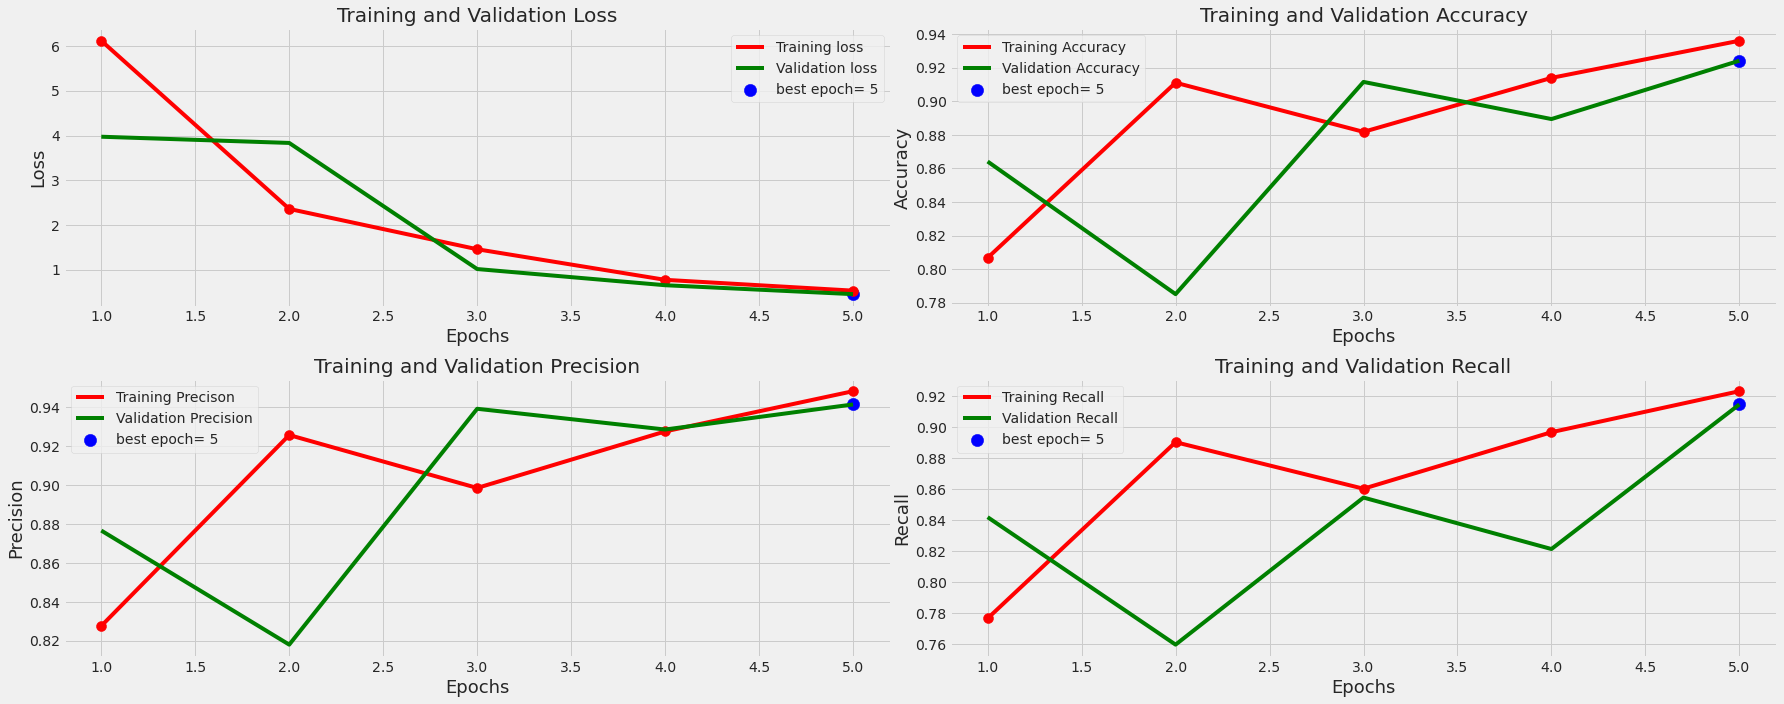

4
211/211 [==============================] - 10s 40ms/step
there were 51 errors in 633 tests for an accuracy of  91.94


<Figure size 432x288 with 0 Axes>

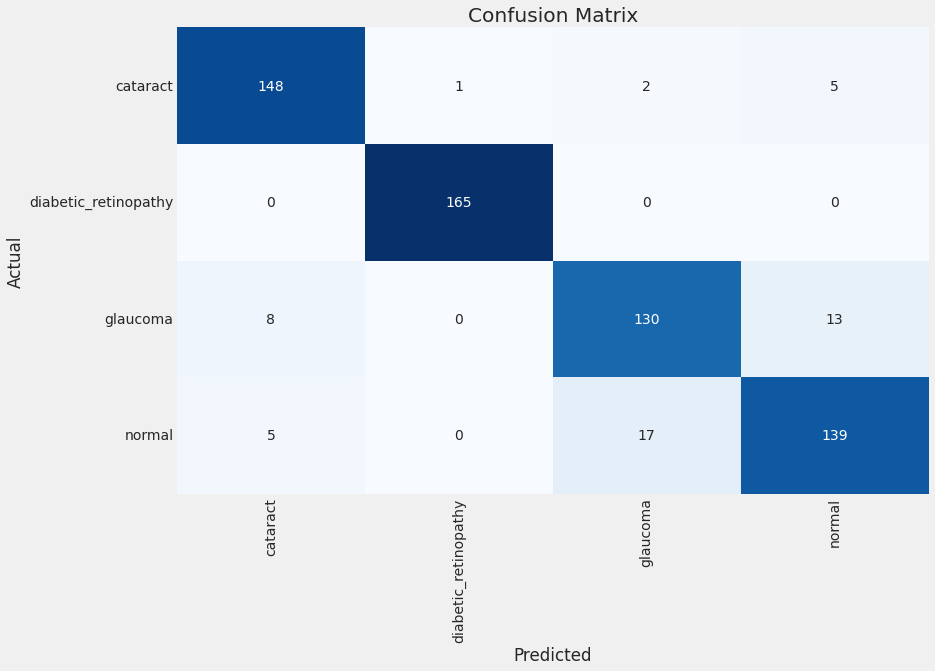

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9193    0.9487    0.9338       156
diabetic_retinopathy     0.9940    1.0000    0.9970       165
            glaucoma     0.8725    0.8609    0.8667       151
              normal     0.8854    0.8634    0.8742       161

            accuracy                         0.9194       633
           macro avg     0.9178    0.9182    0.9179       633
        weighted avg     0.9190    0.9194    0.9191       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.94871795 1.         0.86092715 0.86335404]
91.9087235474876


In [38]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3* Adamax optimizer

In [39]:
model=make_model_finetune(img_size, lr, optimizer_mode=3)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adamax optimizer with initial learning rate set to 0.001
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            

 H


you entered H,  Training halted on epoch 5 due to user input

loading model with weights from epoch 5
training elapsed time was 0.0 hours,  5.0 minutes, 32.00 seconds)


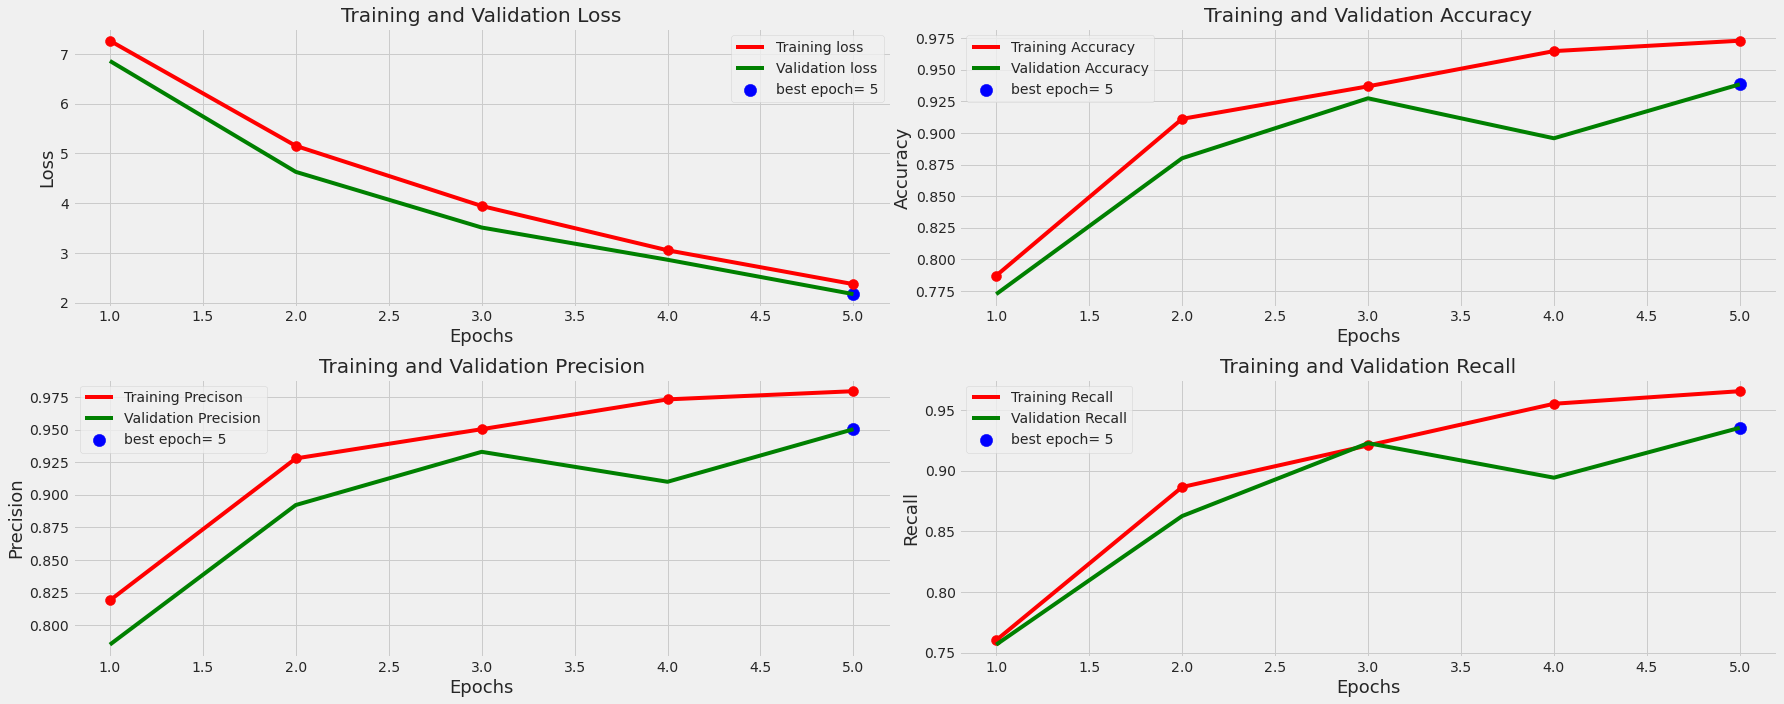

4
211/211 [==============================] - 10s 39ms/step
there were 42 errors in 633 tests for an accuracy of  93.36


<Figure size 432x288 with 0 Axes>

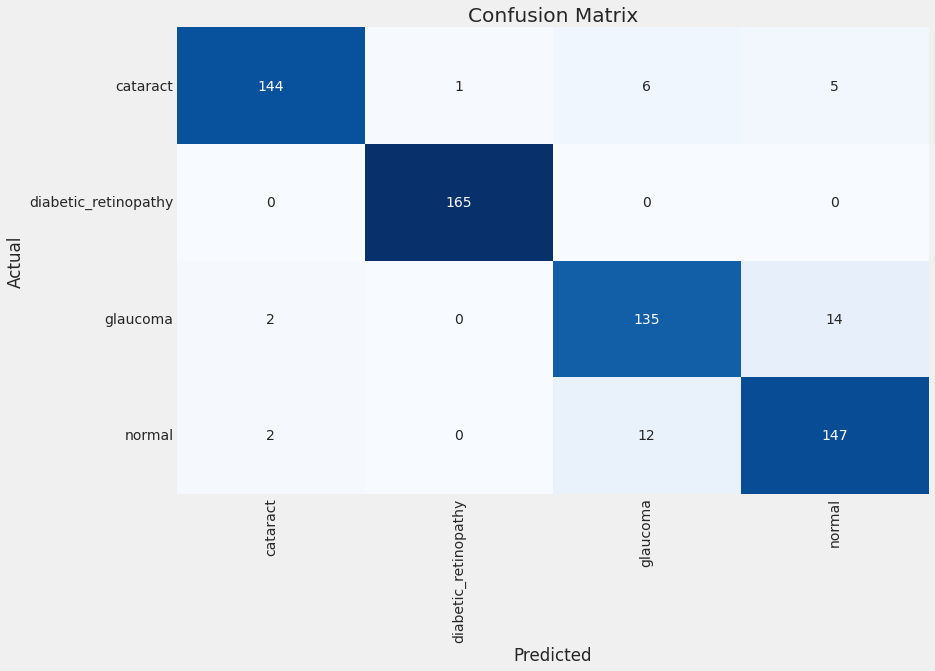

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9730    0.9231    0.9474       156
diabetic_retinopathy     0.9940    1.0000    0.9970       165
            glaucoma     0.8824    0.8940    0.8882       151
              normal     0.8855    0.9130    0.8991       161

            accuracy                         0.9336       633
           macro avg     0.9337    0.9325    0.9329       633
        weighted avg     0.9346    0.9336    0.9339       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.92307692 1.         0.89403974 0.91304348]
93.38943442993262


In [40]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

## *NOT REQUIRED SECTION START*

#### FINETUNE *ResNet50* Adam optimizer

In [41]:
model=make_model_finetune(img_size, lr,mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created ResNet50 model with Adam optimizer with initial learning rate set to 0.001
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________

 H


you entered H,  Training halted on epoch 5 due to user input

loading model with weights from epoch 5
training elapsed time was 0.0 hours,  3.0 minutes, 52.75 seconds)


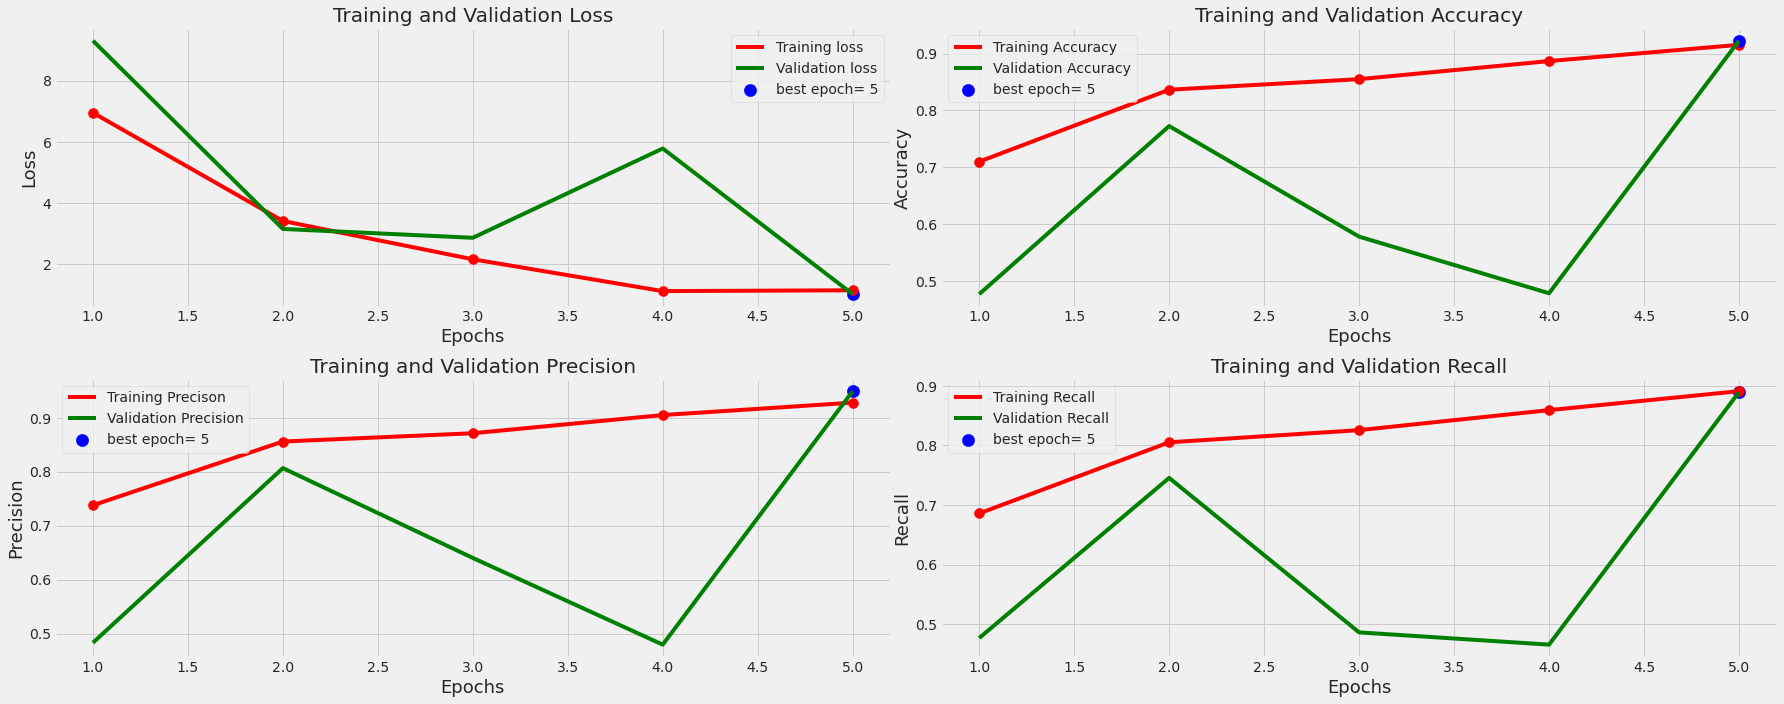

4
211/211 [==============================] - 8s 32ms/step
there were 62 errors in 633 tests for an accuracy of  90.21


<Figure size 432x288 with 0 Axes>

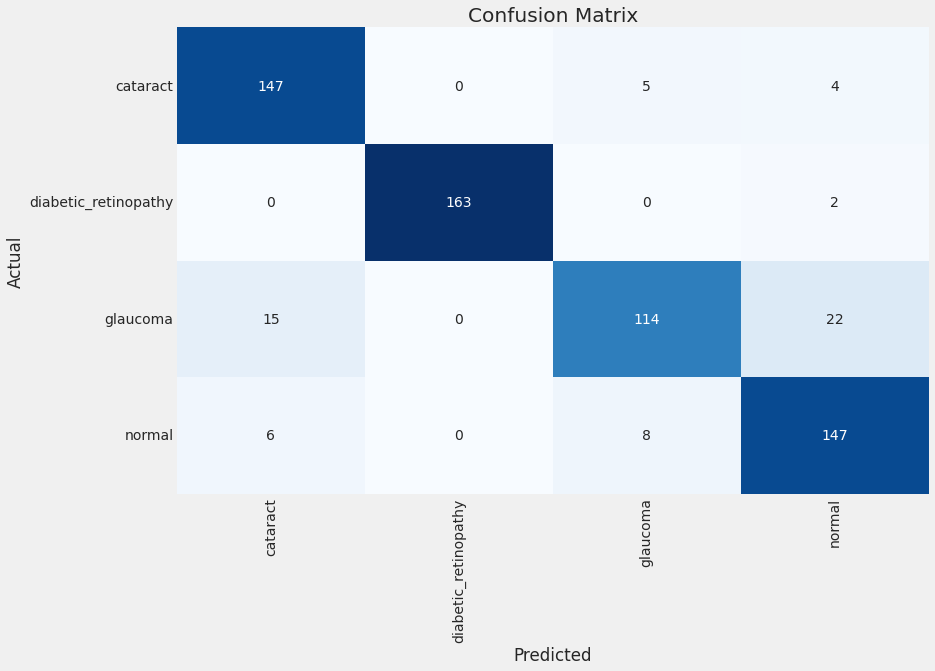

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.8750    0.9423    0.9074       156
diabetic_retinopathy     1.0000    0.9879    0.9939       165
            glaucoma     0.8976    0.7550    0.8201       151
              normal     0.8400    0.9130    0.8750       161

            accuracy                         0.9021       633
           macro avg     0.9032    0.8995    0.8991       633
        weighted avg     0.9041    0.9021    0.9009       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.94230769 0.98787879 0.75496689 0.91304348]
90.0894446466485


In [42]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineResNet50.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### FINETUNE*ResNet50* Adamax optimizer

In [44]:
model=make_model_finetune(img_size, lr, optimizer_mode=3, mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created ResNet50 model with Adamax optimizer with initial learning rate set to 0.001
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______

 2


you entered 2 Training will continue to epoch 7
Epoch 6/40
94/94 [==============================] - 44s 463ms/step - loss: 2.0600 - accuracy: 0.9725 - precision: 0.9758 - recall: 0.9643 - val_loss: 1.9405 - val_accuracy: 0.9352 - val_precision: 0.9388 - val_recall: 0.9210

 validation loss of  1.9405 is 19.8906 % below lowest loss, saving weights from epoch 6   as best weights
Epoch 7/40
94/94 [==============================] - 43s 456ms/step - loss: 1.5938 - accuracy: 0.9879 - precision: 0.9903 - recall: 0.9807 - val_loss: 1.5466 - val_accuracy: 0.9305 - val_precision: 0.9353 - val_recall: 0.9131

 validation loss of  1.5466 is 20.3017 % below lowest loss, saving weights from epoch 7   as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 1


you entered 1 Training will continue to epoch 8
Epoch 8/40
94/94 [==============================] - 44s 472ms/step - loss: 1.2558 - accuracy: 0.9857 - precision: 0.9881 - recall: 0.9814 - val_loss: 1.2392 - val_accuracy: 0.9415 - val_precision: 0.9516 - val_recall: 0.9321

 validation loss of  1.2392 is 19.8760 % below lowest loss, saving weights from epoch 8   as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 2


you entered 2 Training will continue to epoch 10
Epoch 9/40
94/94 [==============================] - 44s 462ms/step - loss: 1.0123 - accuracy: 0.9864 - precision: 0.9889 - recall: 0.9832 - val_loss: 1.0808 - val_accuracy: 0.9210 - val_precision: 0.9324 - val_recall: 0.9147

 validation loss of  1.0808 is 12.7792 % below lowest loss, saving weights from epoch 9   as best weights
Epoch 10/40
94/94 [==============================] - 44s 461ms/step - loss: 0.8285 - accuracy: 0.9829 - precision: 0.9860 - recall: 0.9796 - val_loss: 0.8768 - val_accuracy: 0.9305 - val_precision: 0.9390 - val_recall: 0.9242

 validation loss of  0.8768 is 18.8729 % below lowest loss, saving weights from epoch 10  as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 1


you entered 1 Training will continue to epoch 11
Epoch 11/40
94/94 [==============================] - 43s 460ms/step - loss: 0.6512 - accuracy: 0.9918 - precision: 0.9939 - recall: 0.9882 - val_loss: 0.7318 - val_accuracy: 0.9352 - val_precision: 0.9390 - val_recall: 0.9242

 validation loss of  0.7318 is 16.5453 % below lowest loss, saving weights from epoch 11  as best weights

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 H


you entered H,  Training halted on epoch 11 due to user input

loading model with weights from epoch 11
training elapsed time was 0.0 hours,  8.0 minutes, 53.87 seconds)


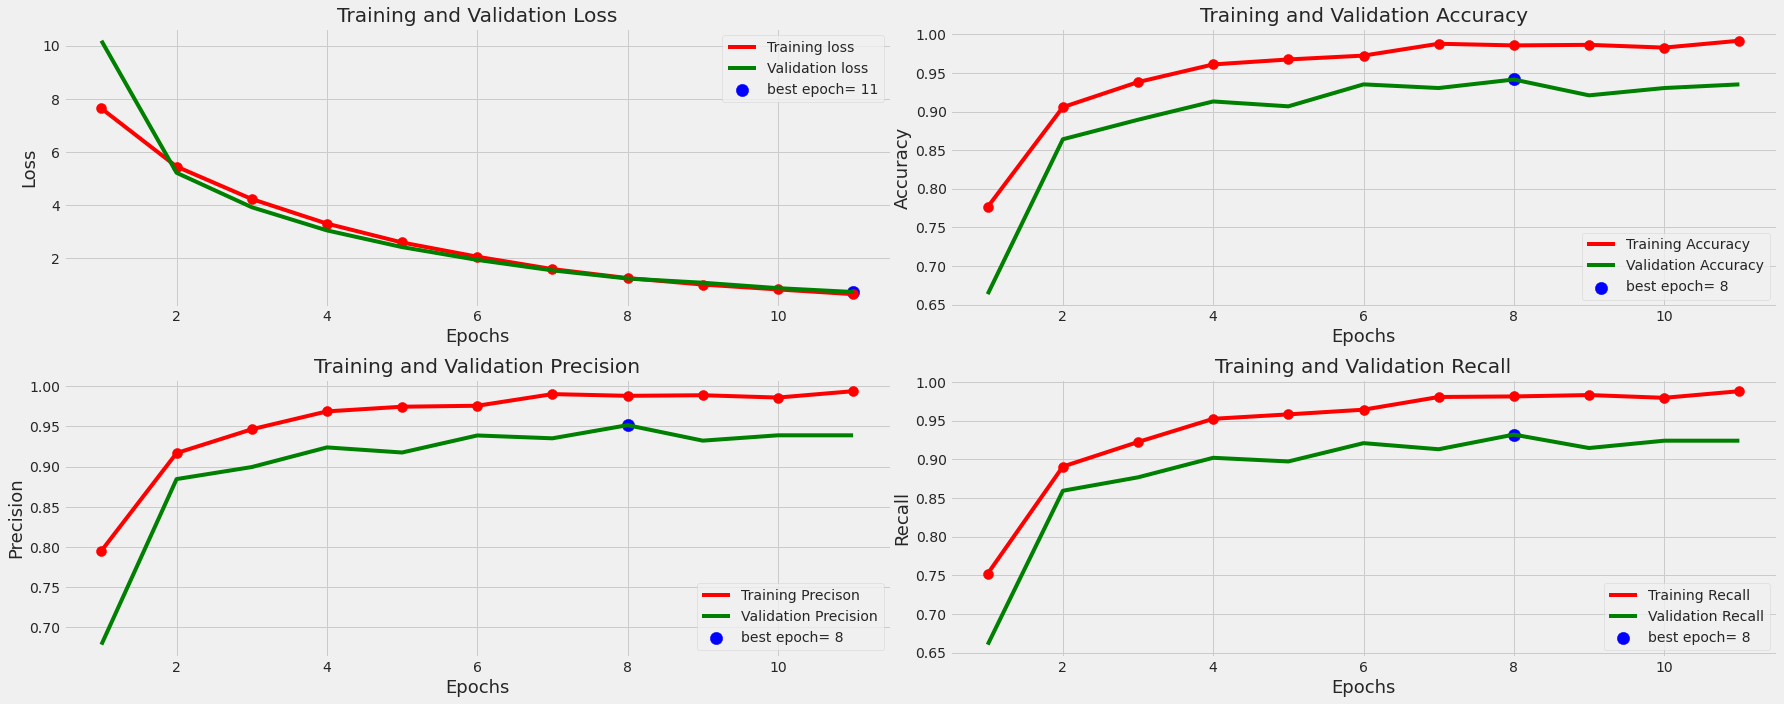

10
211/211 [==============================] - 8s 32ms/step
there were 56 errors in 633 tests for an accuracy of  91.15


<Figure size 432x288 with 0 Axes>

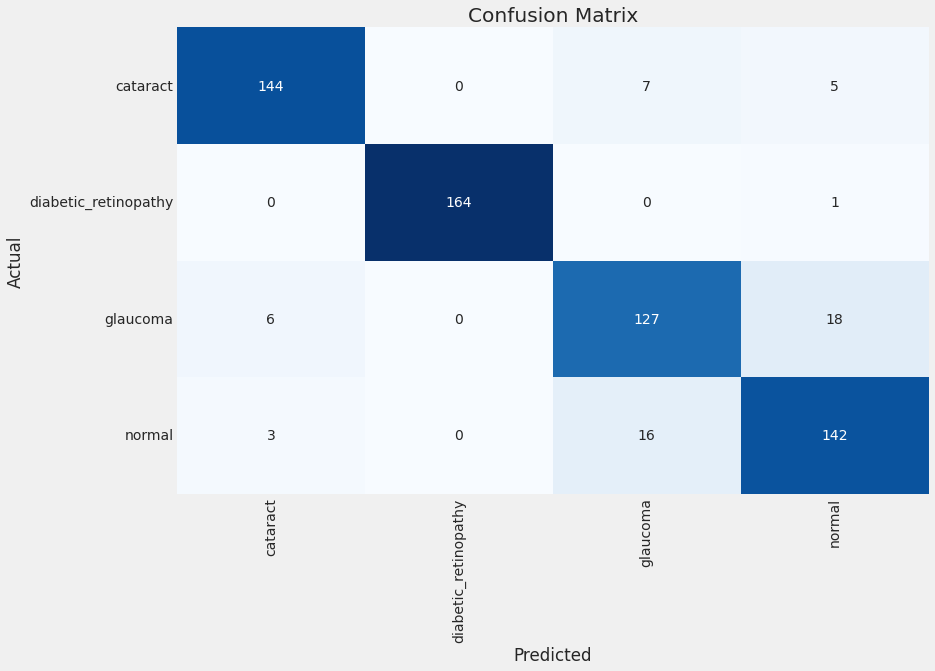

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract     0.9412    0.9231    0.9320       156
diabetic_retinopathy     1.0000    0.9939    0.9970       165
            glaucoma     0.8467    0.8411    0.8439       151
              normal     0.8554    0.8820    0.8685       161

            accuracy                         0.9115       633
           macro avg     0.9108    0.9100    0.9103       633
        weighted avg     0.9122    0.9115    0.9118       633

Accuracy for classes in order C, D, G, N:
----------------------
 [0.92307692 0.99393939 0.8410596  0.88198758]
91.17649472089373


In [45]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineResNet50.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

### Regularizer model

In [38]:
def make_model_regularizer(img_size, lr, mod_num=3, optimizer_mode=2):  # using B3 model by default
    img_shape=(img_size[0], img_size[1], 3)                         # using Adam optimizer by default
    if mod_num == 0:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created VGG19 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created InceptionV3 model'
        
    else:
        base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created ResNet50 model'   
    if msg == 'Created ResNet50 model':
        base_model.trainable=False
    else:
        base_model.trainable=True
        
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.032),activity_regularizer=regularizers.l1(0.016),
                    bias_regularizer=regularizers.l1(0.016) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    if optimizer_mode == 1:
        model.compile(SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with SGD optimizer'
    if optimizer_mode == 2:
        model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adam optimizer'
    if optimizer_mode == 3:
        model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
        msg=msg+' with Adamax optimizer'

    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    model.summary()
    return model

lr=.001

#### ResNet + Regularizer

In [39]:
model=make_model_regularizer(img_size, lr, mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created ResNet50 model with Adam optimizer with initial learning rate set to 0.001

Model: "model_12"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            

__________________________________________________________________________________________________

conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_13[0][0]                   

__________________________________________________________________________________________________

conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  

__________________________________________________________________________________________________

conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]               

 1


you entered 1 Training will continue to epoch 6

Epoch 6/40

40/40 [==============================] - 18s 459ms/step - loss: 1.0124 - accuracy: 0.9542 - precision: 0.9716 - recall: 0.9125 - val_loss: 1.0988 - val_accuracy: 0.8578 - val_precision: 0.8848 - val_recall: 0.8373



 validation loss of  1.0988 is 11.5779 % below lowest loss, saving weights from epoch 6   as best weights



 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 1


you entered 1 Training will continue to epoch 7

Epoch 7/40

40/40 [==============================] - 19s 469ms/step - loss: 0.8812 - accuracy: 0.9533 - precision: 0.9710 - recall: 0.9208 - val_loss: 0.9712 - val_accuracy: 0.8878 - val_precision: 0.9073 - val_recall: 0.8499



 validation loss of  0.9712 is 11.6131 % below lowest loss, saving weights from epoch 7   as best weights



 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 H


you entered H,  Training halted on epoch 7 due to user input



loading model with weights from epoch 7

training elapsed time was 0.0 hours,  2.0 minutes, 27.03 seconds)


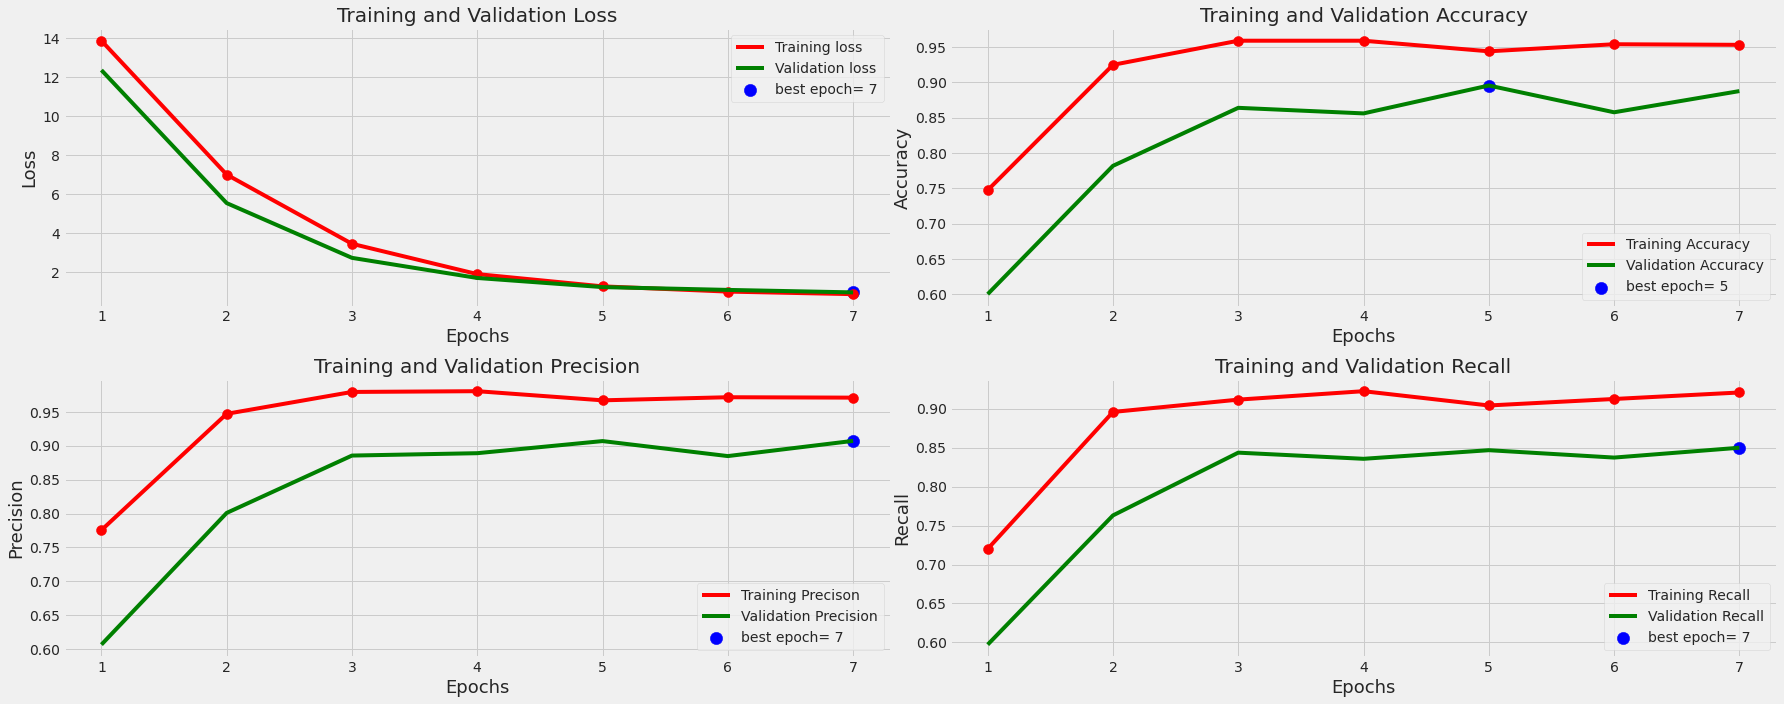

6

211/211 [==============================] - 8s 35ms/step

there were 91 errors in 633 tests for an accuracy of  85.62


<Figure size 432x288 with 0 Axes>

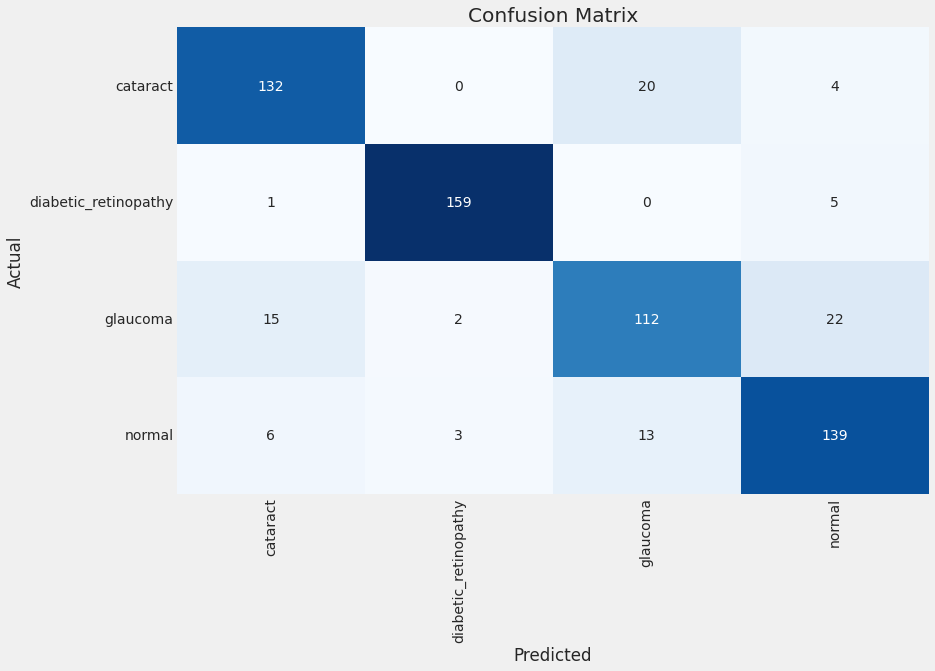

Classification Report:

----------------------

                       precision    recall  f1-score   support



            cataract     0.8571    0.8462    0.8516       156

diabetic_retinopathy     0.9695    0.9636    0.9666       165

            glaucoma     0.7724    0.7417    0.7568       151

              normal     0.8176    0.8634    0.8399       161



            accuracy                         0.8562       633

           macro avg     0.8542    0.8537    0.8537       633

        weighted avg     0.8562    0.8562    0.8560       633



Accuracy for classes in order C, D, G, N:

----------------------

 [0.84615385 0.96363636 0.74172185 0.86335404]

85.59647861846992


In [40]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'ResNetRegularizer.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### EfficientNetB3 + Regularizer

In [41]:
model=make_model_regularizer(img_size, lr)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adam optimizer with initial learning rate set to 0.001

Model: "model_13"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            

__________________________________________________________________________________________________

rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_14[0][0]                   

__________________________________________________________________________________________________

normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                

__________________________________________________________________________________________________

stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]   

 3


you entered 3 Training will continue to epoch 8

Epoch 6/40

40/40 [==============================] - 24s 587ms/step - loss: 0.6257 - accuracy: 0.9842 - precision: 0.9890 - recall: 0.9758 - val_loss: 0.8457 - val_accuracy: 0.8689 - val_precision: 0.8876 - val_recall: 0.8483



 validation loss of  0.8457 is 29.3105 % below lowest loss, saving weights from epoch 6   as best weights

Epoch 7/40

40/40 [==============================] - 24s 602ms/step - loss: 0.6200 - accuracy: 0.9533 - precision: 0.9625 - recall: 0.9417 - val_loss: 1.3199 - val_accuracy: 0.8878 - val_precision: 0.9106 - val_recall: 0.8689



 validation loss of  1.3199 is 56.0746 % above lowest loss of  0.8457 keeping weights from epoch 6 as best weights

learning rate was automatically adjusted from 0.001000 to 0.000400, model weights set to best weights

Epoch 8/40

40/40 [==============================] - 23s 576ms/step - loss: 0.5102 - accuracy: 0.9842 - precision: 0.9881 - recall: 0.9717 - val_loss: 0.6107 - val_acc

 H


you entered H,  Training halted on epoch 8 due to user input



loading model with weights from epoch 8

training elapsed time was 0.0 hours,  3.0 minutes, 53.42 seconds)


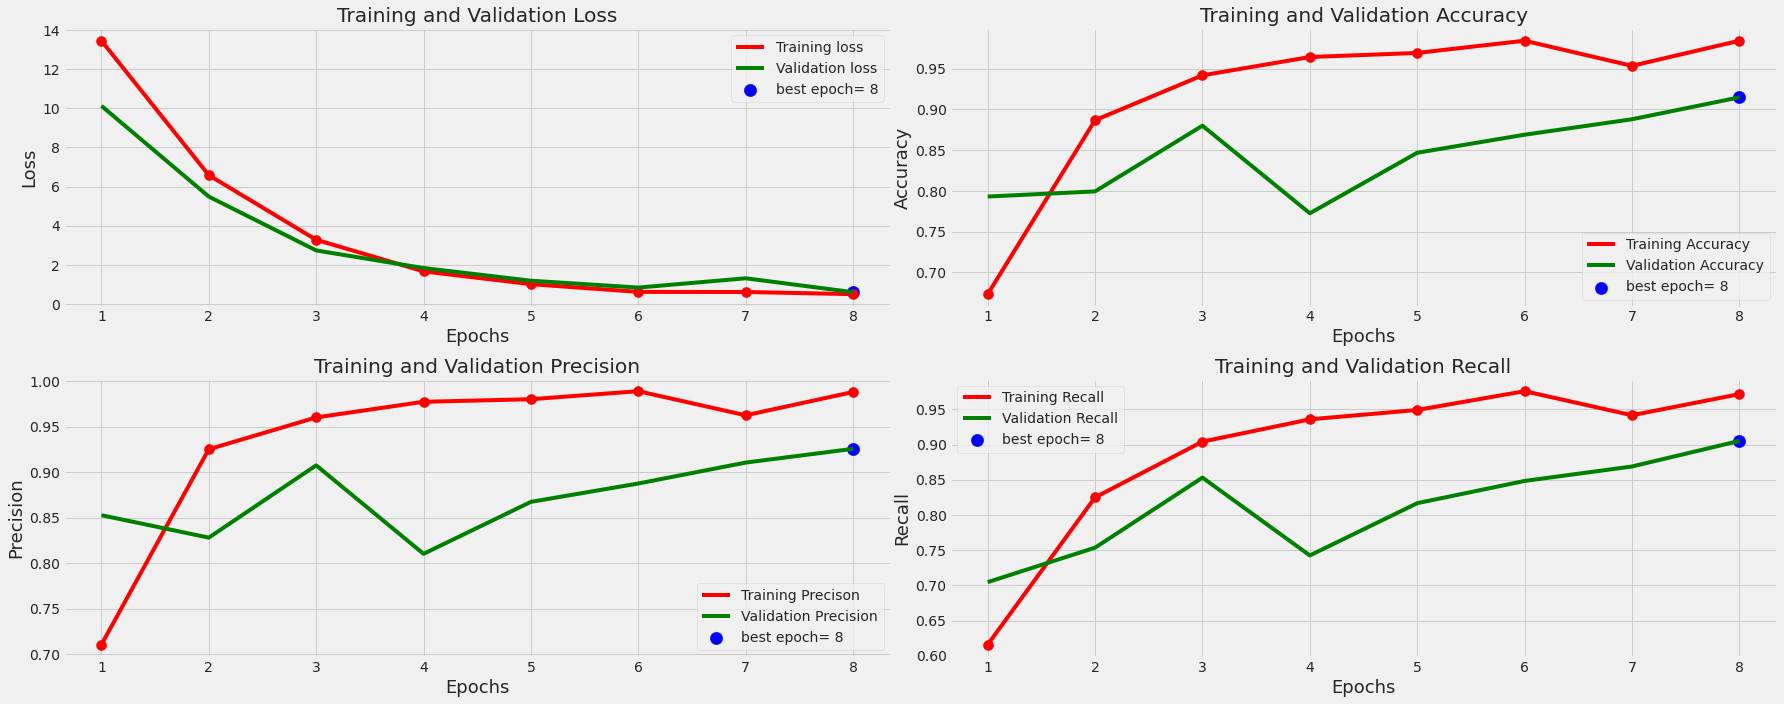

7

211/211 [==============================] - 9s 36ms/step

there were 57 errors in 633 tests for an accuracy of  91.00


<Figure size 432x288 with 0 Axes>

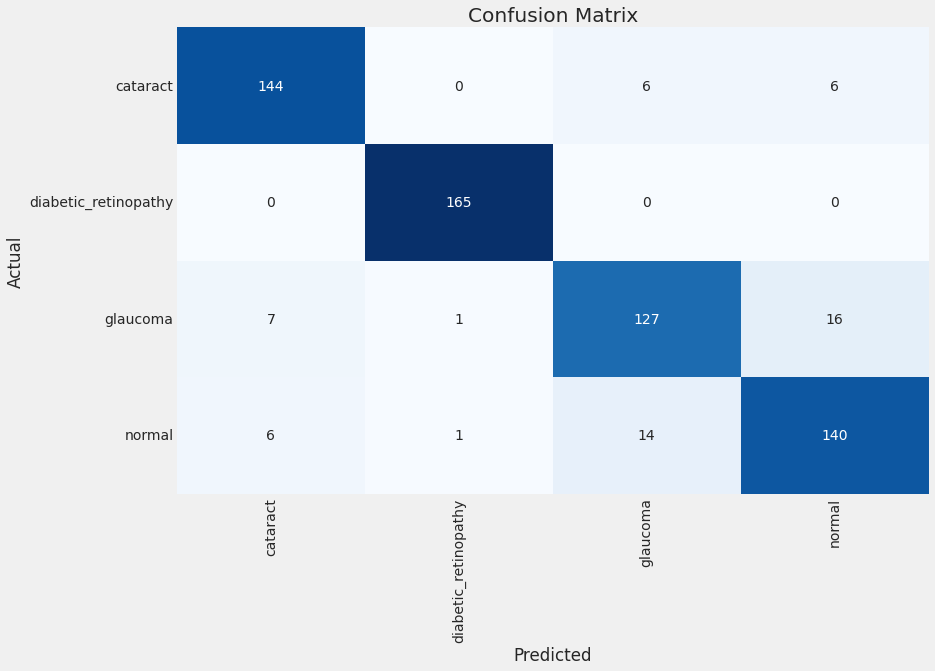

Classification Report:

----------------------

                       precision    recall  f1-score   support



            cataract     0.9172    0.9231    0.9201       156

diabetic_retinopathy     0.9880    1.0000    0.9940       165

            glaucoma     0.8639    0.8411    0.8523       151

              normal     0.8642    0.8696    0.8669       161



            accuracy                         0.9100       633

           macro avg     0.9083    0.9084    0.9083       633

        weighted avg     0.9095    0.9100    0.9097       633



Accuracy for classes in order C, D, G, N:

----------------------

 [0.92307692 1.         0.8410596  0.86956522]

90.96638572712344


In [42]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'ResNetRegularizer.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### EffiecientB3 + Regularizer + Adamax

In [43]:
model=make_model_regularizer(img_size, lr, optimizer_mode=3)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with Adamax optimizer with initial learning rate set to 0.001

Model: "model_14"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            

__________________________________________________________________________________________________

rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_15[0][0]                   

__________________________________________________________________________________________________

normalization_6 (Normalization) (None, 224, 224, 3)  7           rescaling_6[0][0]                

__________________________________________________________________________________________________

stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_6[0][0] 

 3


you entered 3 Training will continue to epoch 8

Epoch 6/40

40/40 [==============================] - 24s 601ms/step - loss: 4.4372 - accuracy: 0.9733 - precision: 0.9851 - recall: 0.9392 - val_loss: 4.1999 - val_accuracy: 0.8768 - val_precision: 0.9022 - val_recall: 0.8452



 validation loss of  4.1999 is 18.9204 % below lowest loss, saving weights from epoch 6   as best weights

Epoch 7/40

40/40 [==============================] - 25s 611ms/step - loss: 3.6743 - accuracy: 0.9708 - precision: 0.9852 - recall: 0.9433 - val_loss: 3.4494 - val_accuracy: 0.9021 - val_precision: 0.9195 - val_recall: 0.8657



 validation loss of  3.4494 is 17.8699 % below lowest loss, saving weights from epoch 7   as best weights

Epoch 8/40

40/40 [==============================] - 25s 621ms/step - loss: 3.0030 - accuracy: 0.9800 - precision: 0.9923 - recall: 0.9708 - val_loss: 2.8546 - val_accuracy: 0.9084 - val_precision: 0.9223 - val_recall: 0.8815



 validation loss of  2.8546 is 17.2427 % below low

 H


you entered H,  Training halted on epoch 8 due to user input



loading model with weights from epoch 8

training elapsed time was 0.0 hours,  3.0 minutes, 41.38 seconds)


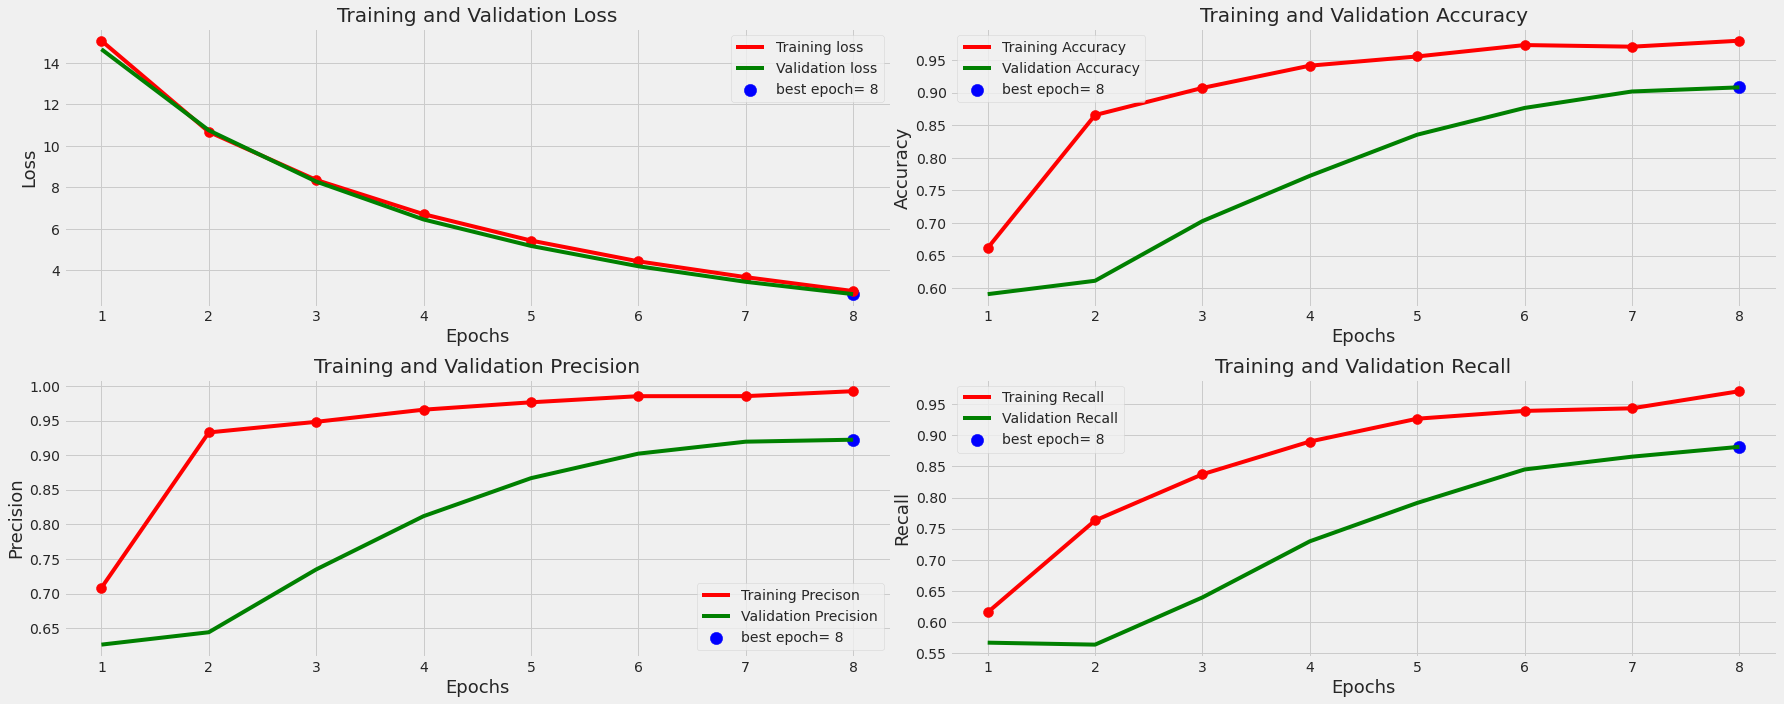

7

211/211 [==============================] - 9s 35ms/step

there were 58 errors in 633 tests for an accuracy of  90.84


<Figure size 432x288 with 0 Axes>

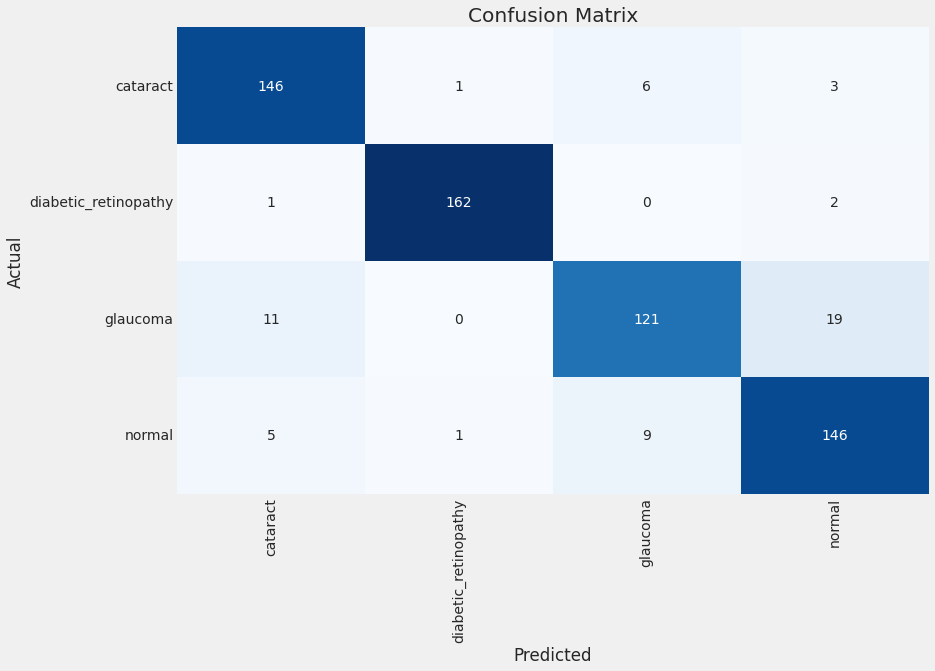

Classification Report:

----------------------

                       precision    recall  f1-score   support



            cataract     0.8957    0.9359    0.9154       156

diabetic_retinopathy     0.9878    0.9818    0.9848       165

            glaucoma     0.8897    0.8013    0.8432       151

              normal     0.8588    0.9068    0.8822       161



            accuracy                         0.9084       633

           macro avg     0.9080    0.9065    0.9064       633

        weighted avg     0.9089    0.9084    0.9078       633



Accuracy for classes in order C, D, G, N:

----------------------

 [0.93589744 0.98181818 0.8013245  0.9068323 ]

90.78086773341686


In [44]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'B3Regularizer.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *VGG19*

In [ ]:
model=make_model_finetune(img_size, lr, mod_num=0)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'finevgg19.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *InceptionV3*

In [ ]:
model=make_model_finetune(img_size, lr, mod_num=5)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineInception.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *ResNet50*

In [ ]:
model=make_model_finetune(img_size, lr, mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'fineResNet.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

### Hybrid

In [ ]:
def make_model_hybrid(img_size, lr, mod_num=3):  # using B3 model by default
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created VGG19 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created InceptionV3 model'
        
    else:
        base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created ResNet50 model'   
   
    base_model.trainable=False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = tf.keras.layers.Reshape((1,x.shape[1]))(x)
    x = tf.keras.layers.LSTM(32,return_sequences=False,dropout=0.4,kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.016) ,activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(64, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    model.summary()
    return model

lr=.001

#### *VGG19*

In [ ]:
model=make_model_hybrid(img_size, lr, mod_num=0)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]
model.summary()
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'hybridvgg19.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *InceptionV3*

In [ ]:
model=make_model_hybrid(img_size, lr, mod_num=5)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'hybridInception.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *ResNet50*

In [ ]:
model=make_model_hybrid(img_size, lr, mod_num=7)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'hybridResNet.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)

#### *Efficient Net B3*

In [ ]:
model=make_model_hybrid(img_size, lr)
# instantiate custom callback
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
# plotting loss and accuracy    
loss_index=tr_plot(history,0,'hybridEfficientNetB3.pdf')
print(loss_index)
# predictions on test_gen
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print(f1score)